## Predicting Teacher Attrition Rates for Public Schools
**This notebook explores predicting teacher attrition rates for public schools in North Carolina.** 
* Public school data, county crime rate data and school income tax data are considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/wtubin/TeacherRetentionofNC

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
#!pip install xgboost
#!pip install pyshp
#!pip install ml_metrics 
# need c++ 1.04 http://go.microsoft.com/fwlink/?LinkId=691126&fixForIE=.exe.
#!pip install minepy 

In [2]:
#import required Libraries
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns; #sns.set()
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV    
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from yellowbrick.features import JointPlotVisualizer
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import xgboost
import scipy.stats as stats



import warnings
warnings.simplefilter('ignore')

%matplotlib inline


In [3]:

ML2017 = '../Machine Learning Datasets/PublicSchools2017_ML.csv'
# ML2016 = '../2016/Machine Learning Datasets/PublicSchools2016_ML.csv'
# ML2015 =  '../2015/Machine Learning Datasets/PublicSchools2015_ML.csv'
# ML2014 =  '../2014/Machine Learning Datasets/PublicSchools2014_ML.csv'

schData2017=pd.read_csv(ML2017, low_memory=False)
print('*********************************2017 ML Data*************************************')
schData2017.info()
# schData2016=pd.read_csv(ML2016, low_memory=False)
# print('*********************************2016 ML Data*************************************')
# schData2016.info()

# schData2015=pd.read_csv(ML2015, low_memory=False)
# print('*********************************2015 ML Data*************************************')
# schData2015.info()

# schData2014=pd.read_csv(ML2014, low_memory=False)
# print('*********************************2014 ML Data*************************************')
# schData2014.info()

*********************************2017 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 407 entries, student_num to unit_code
dtypes: float64(363), int64(44)
memory usage: 7.7 MB


## Fix Year

In [4]:
# schData2014["Year"]=2014
# schData2015["Year"]=2015
# schData2016["Year"]=2016
schData2017["Year"]=2017

In [5]:
# Combine the data sets
# schData = pd.concat([schData2017,schData2016,schData2015,schData2014], axis=0, ignore_index=True, sort = True)
schData = schData2017

## Remove missing data after merge

In [6]:
#Missing Data Threshold (Per Column)
missingThreshold = 0.60

#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 25


#Eliminate continuous columns with more than missingThreshold percentage of missing values
schoolDataRecordCt = schData.shape[0]
missingValueLimit = schoolDataRecordCt * missingThreshold
NullValueCounts = schData.isnull().sum()
NullValueCols = NullValueCounts[NullValueCounts >= missingValueLimit].index
schData = schData.drop(NullValueCols, axis=1)

#Review dataset contents after empty field drops
print('*********After: Removing columns with >= missingThreshold % of missing values******')
schData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(NullValueCols))


*********After: Removing columns with >= missingThreshold % of missing values******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 407 entries, student_num to unit_code
dtypes: float64(362), int64(45)
memory usage: 7.7 MB

Columns Deleted:  0


In [7]:
#Replace all remaining NaN with 0
schData = schData.fillna(0)

#Check for Missing values after final imputation 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

Empty DataFrame
Columns: [Variable Name, Number Missing Values]
Index: []

In [8]:
schData['_1yr_tchr_trnovr_pct'].describe()
# 'Number of farm returns All',
# 'Number of farm returns 100KLT200K'
# 'Number of farm returns LT25K',
# 'Number of farm returns 25KLT50K',
# 'Number of farm returns 50KLT75K',
# 'Number of farm returns 75KLT100K',
# 'Number of farm returns GE200K'

count    2468.000000
mean        0.135515
std         0.085821
min         0.000000
25%         0.077000
50%         0.125000
75%         0.182000
max         0.667000
Name: _1yr_tchr_trnovr_pct, dtype: float64

In [9]:
len(schData[schData['_1yr_tchr_trnovr_pct']==0.0].index)


143

### Response variable imputation.

In [10]:
# # https://ncreportcards.ondemand.sas.com/src/school?school=840344&year=2017&lang=english
# # verified the 1 year teacher turn over rate from above website. it looks like these are 0
# zeroAttrition = schData[schData['_1yr_tchr_trnovr_pct']==0.0].index

# #schData = schData.drop(zeroAttrition,axis=0)
# schData['_1yr_tchr_trnovr_pct'][schData['_1yr_tchr_trnovr_pct']==0.0] = 0.001

# #print('*********After: Removing rows with first year turn over percentage =0.00******')
# print('*********After: change turn over percentage =0.01******')
# schData.info(verbose=False)
# print ('\r\nRows Deleted: ', len(zeroAttrition))

In [11]:
# impute 0.001 to avoid devided by zero
schData[schData['_1yr_tchr_trnovr_pct']==0.0]['_1yr_tchr_trnovr_pct'] = 0.001

## Visulization

### Heat map

#### 1 Year Teacher Turnover

<img src="North Carolina 2017 One Year Teacher Attrition Rate by zip code.png"></img>

#### Crime Index Rate

<img src="North Carolina 2017 Crame Index Rate by zip code.png"></img>

### Histogram

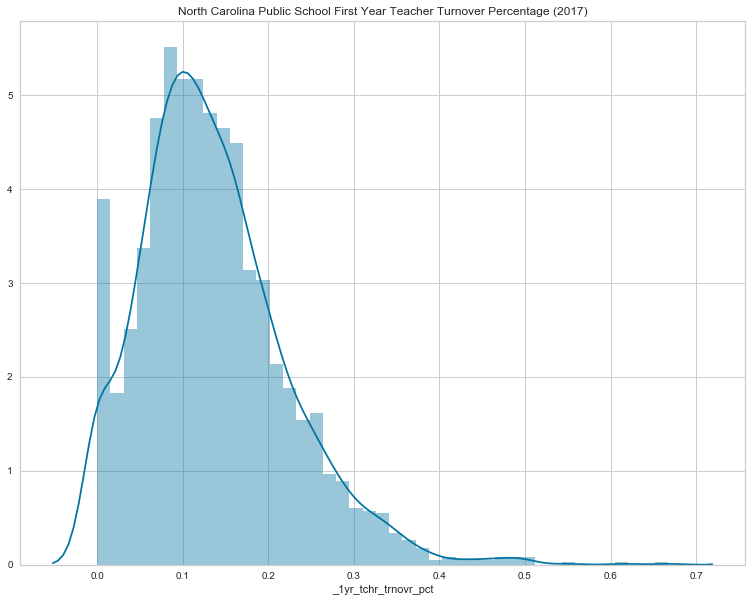

In [12]:
plt.figure(figsize=(13,10))
_1yr_tchr_trnovr_pct = schData["_1yr_tchr_trnovr_pct"]
ax = sns.distplot(_1yr_tchr_trnovr_pct);
plt.title("North Carolina Public School First Year Teacher Turnover Percentage (2017)")
plt.show()



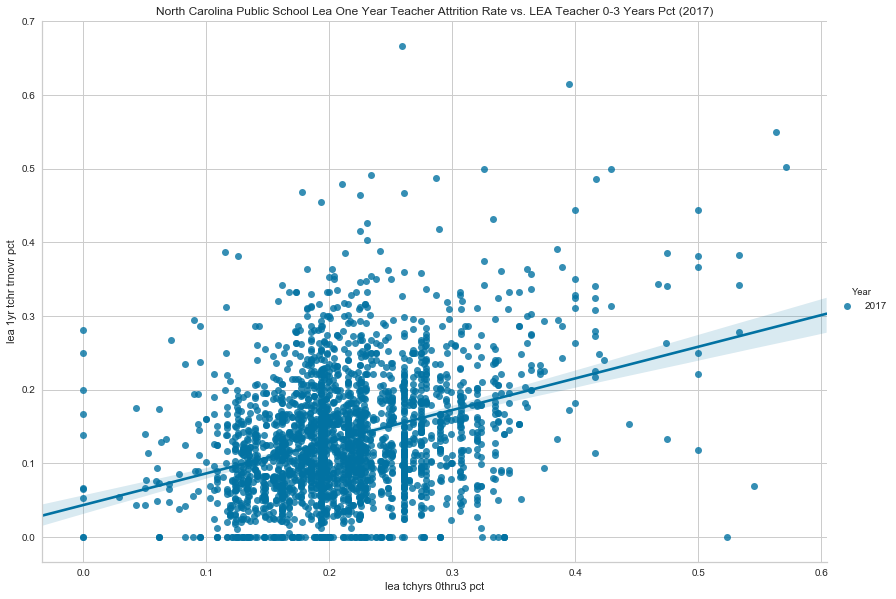

In [13]:
# #sns.set_style("darkgrid")
data = schData
sns.lmplot(x="lea_tchyrs_0thru3_pct", y="_1yr_tchr_trnovr_pct", hue = "Year",  data=data,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("North Carolina Public School Lea One Year Teacher Attrition Rate vs. LEA Teacher 0-3 Years Pct (2017)")
plt.ylabel('lea 1yr tchr trnovr pct')
plt.xlabel('lea tchyrs 0thru3 pct')

plt.savefig('Lea_tchyrs_0thru3_pct_1yr_tchr_trnovr_pct.png')
plt.show()

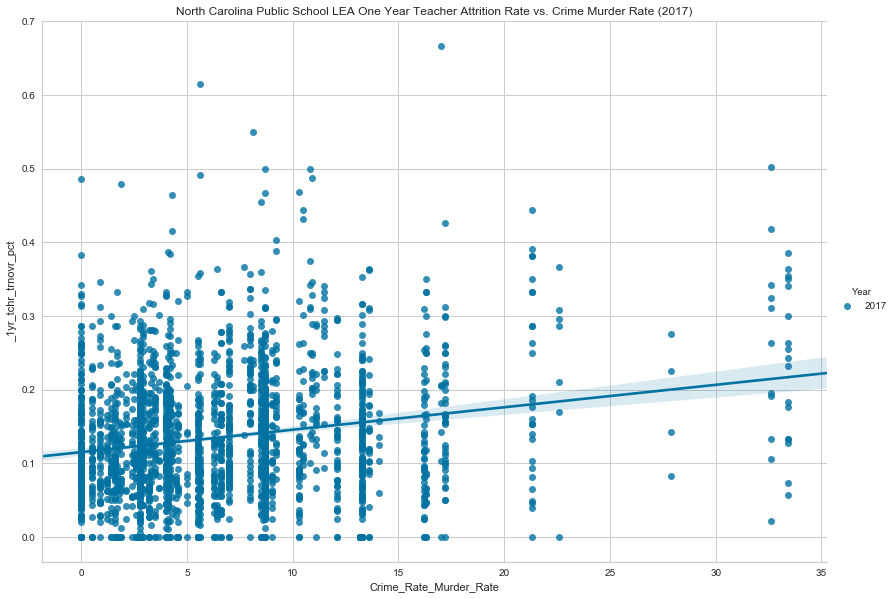

In [14]:
# #sns.set_style("darkgrid")
data = schData
sns.lmplot(x="Crime_Rate_Murder_Rate", y="_1yr_tchr_trnovr_pct", hue="Year",  data=data,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("North Carolina Public School LEA One Year Teacher Attrition Rate vs. Crime Murder Rate (2017)")
plt.ylabel('_1yr_tchr_trnovr_pct')
plt.xlabel('Crime_Rate_Murder_Rate')
#plt.show()
plt.savefig('Crime_Rate_Murder_Rate_1yr_tchr_trnovr_pct.png')


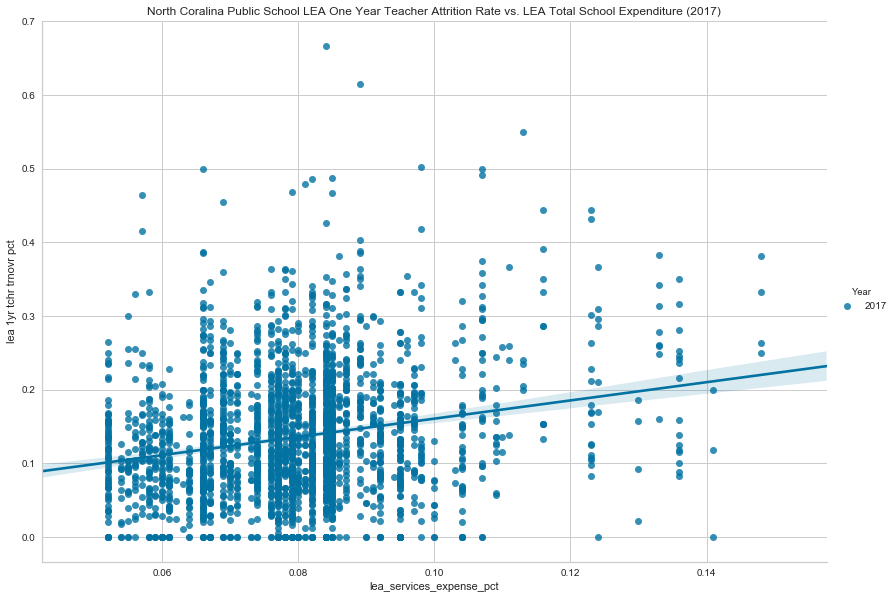

In [15]:
sns.lmplot(x="lea_services_expense_pct", y="_1yr_tchr_trnovr_pct", hue="Year", data=schData,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("North Coralina Public School LEA One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2017)")
plt.ylabel('lea 1yr tchr trnovr pct')
plt.xlabel('lea_services_expense_pct')
plt.savefig('lea_services_expense_pct__1yr_tchr_trnovr_pct.png')

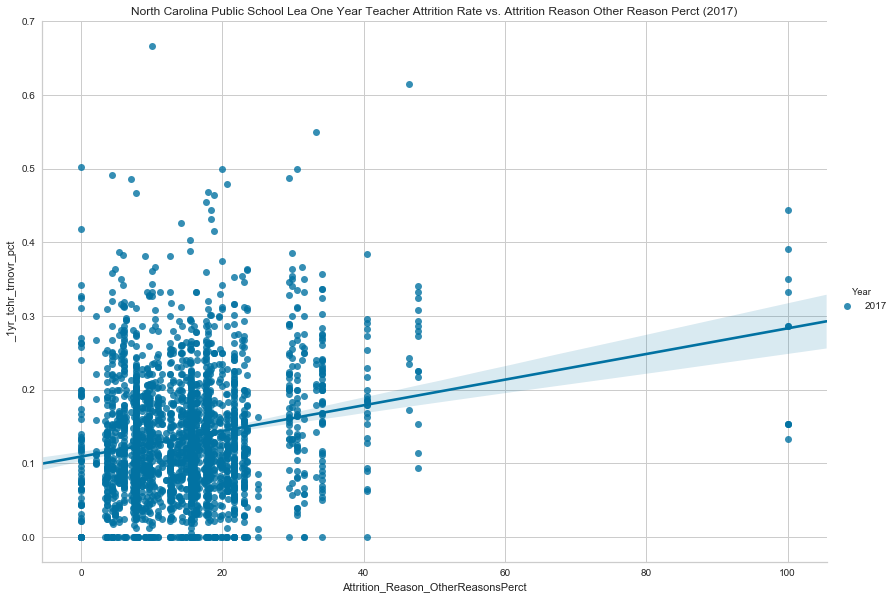

In [16]:
# #sns.set_style("darkgrid")
data = schData
sns.lmplot(x="Attrition_Reason_OtherReasonsPerct", y="_1yr_tchr_trnovr_pct", hue = "Year",  data=data,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("North Carolina Public School Lea One Year Teacher Attrition Rate vs. Attrition Reason Other Reason Perct (2017)")
plt.ylabel('_1yr_tchr_trnovr_pct')
plt.xlabel('Attrition_Reason_OtherReasonsPerct')

plt.savefig('Attrition_Reason_OtherReasonsPerct_1yr_tchr_trnovr_pct.png')
plt.show()

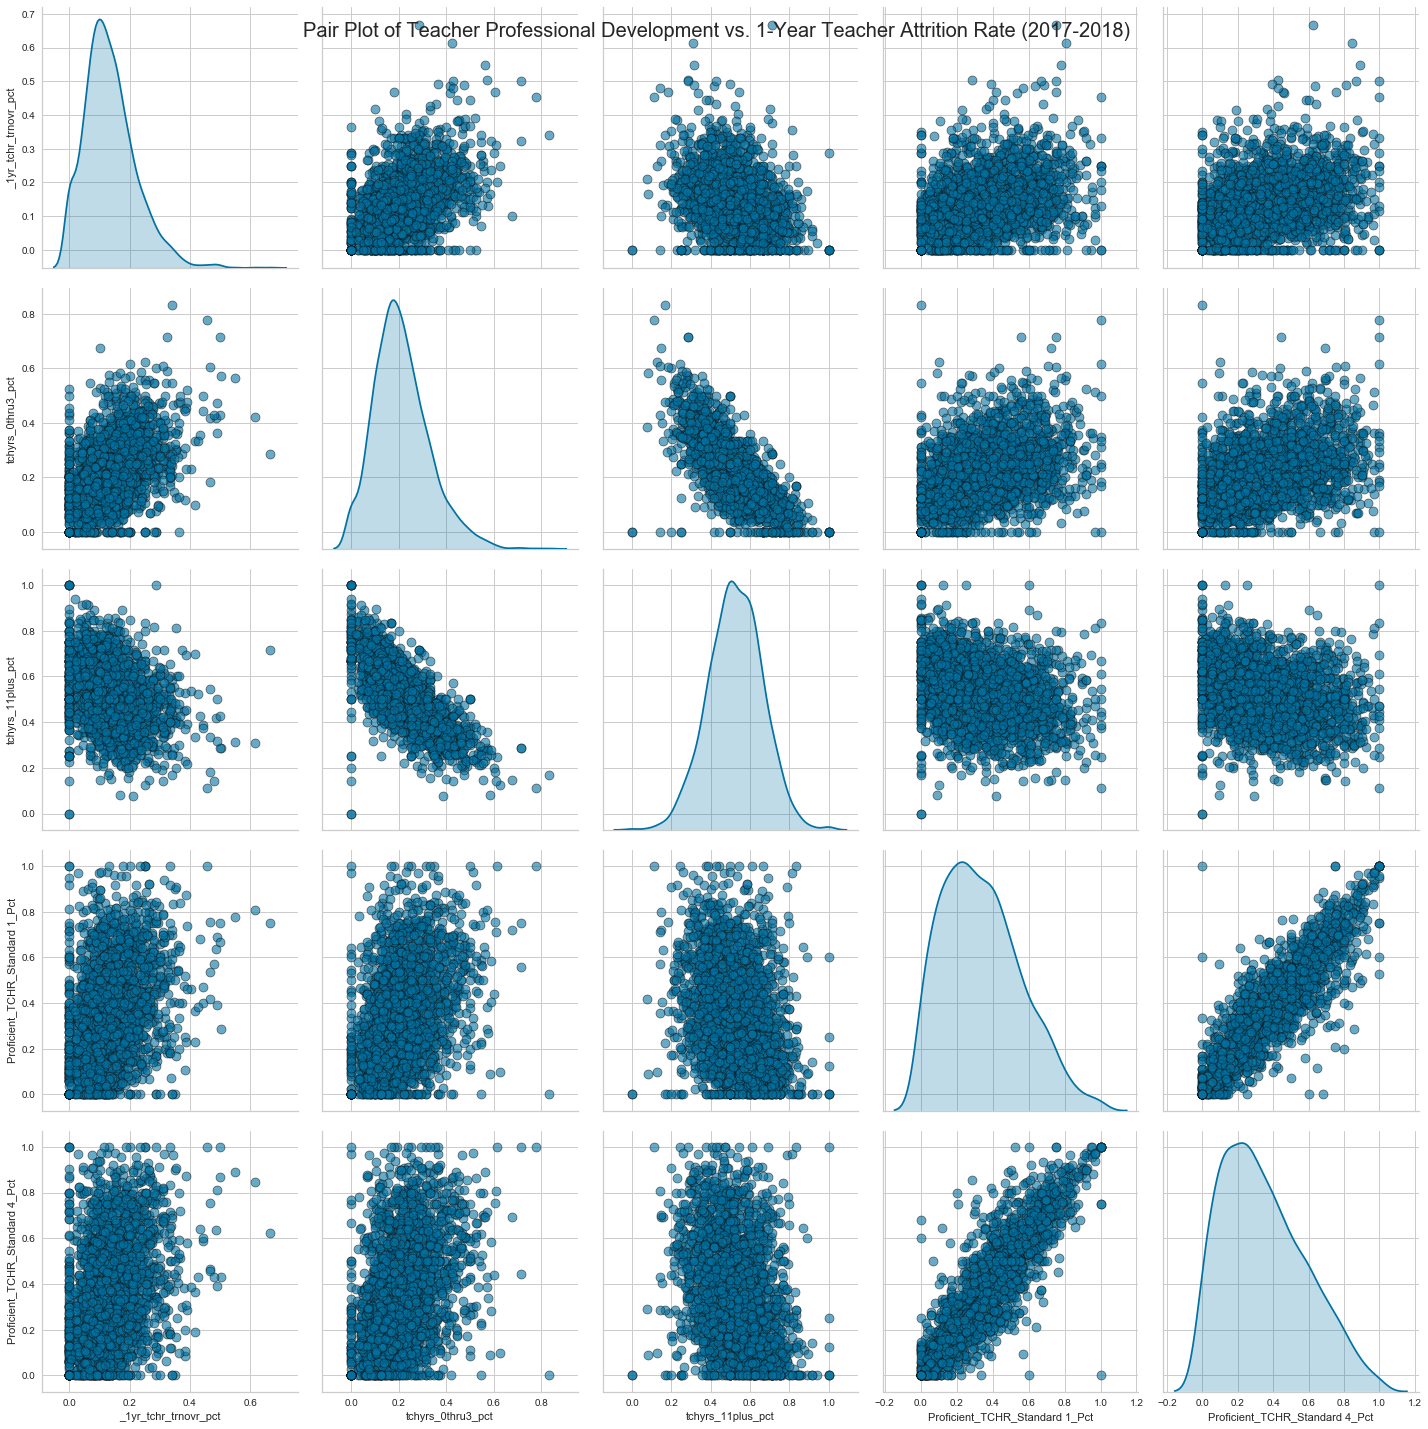

In [17]:
# pair plot for teacher experiences
teacherProf = schData[['_1yr_tchr_trnovr_pct','tchyrs_0thru3_pct','tchyrs_11plus_pct','Proficient_TCHR_Standard 1_Pct','Proficient_TCHR_Standard 4_Pct']]
sns.pairplot(teacherProf
             ,vars = ['_1yr_tchr_trnovr_pct','tchyrs_0thru3_pct','tchyrs_11plus_pct','Proficient_TCHR_Standard 1_Pct','Proficient_TCHR_Standard 4_Pct']
             , diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},height = 4)
# Title 
plt.suptitle('Pair Plot of Teacher Professional Development vs. 1-Year Teacher Attrition Rate (2017-2018)', 
             size = 20);

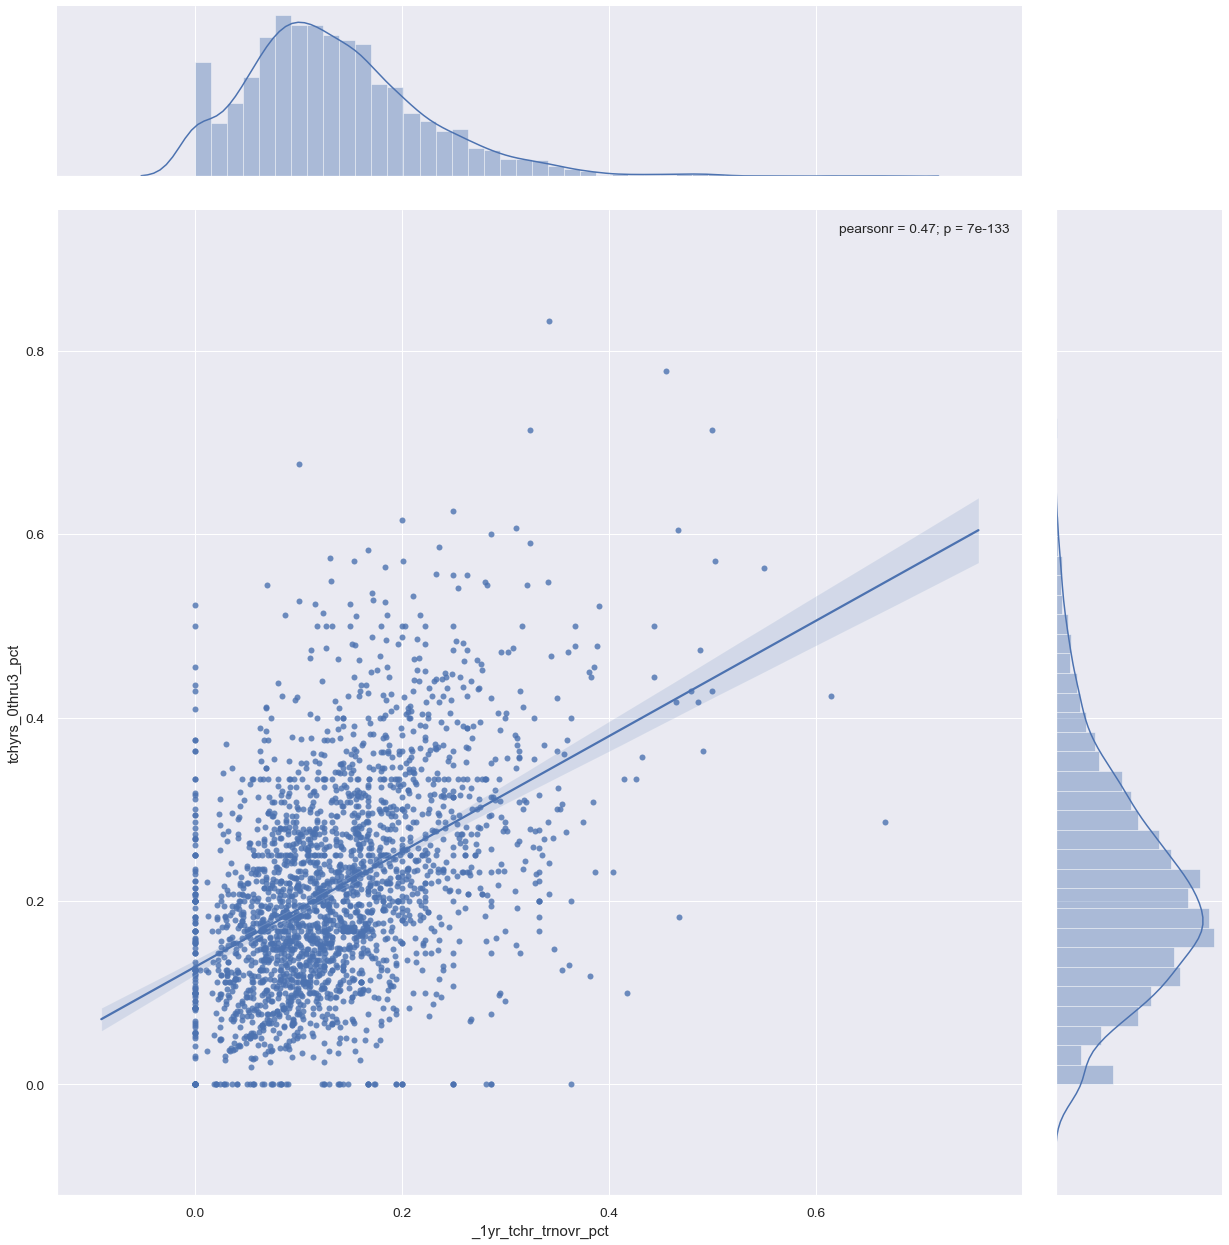

In [18]:
import scipy.stats as stats
sns.set(context='notebook', style='darkgrid', font_scale=1.25)
my_plot = sns.jointplot(x='_1yr_tchr_trnovr_pct', y='tchyrs_0thru3_pct', data=data, kind="reg");
my_plot .annotate(stats.pearsonr)
my_plot.fig.set_figwidth(20)
my_plot.fig.set_figheight(20)
my_plot.savefig("_1yr_tchr_trnovr_pct_tchyrs_0thru3_pct_jointplot.png")

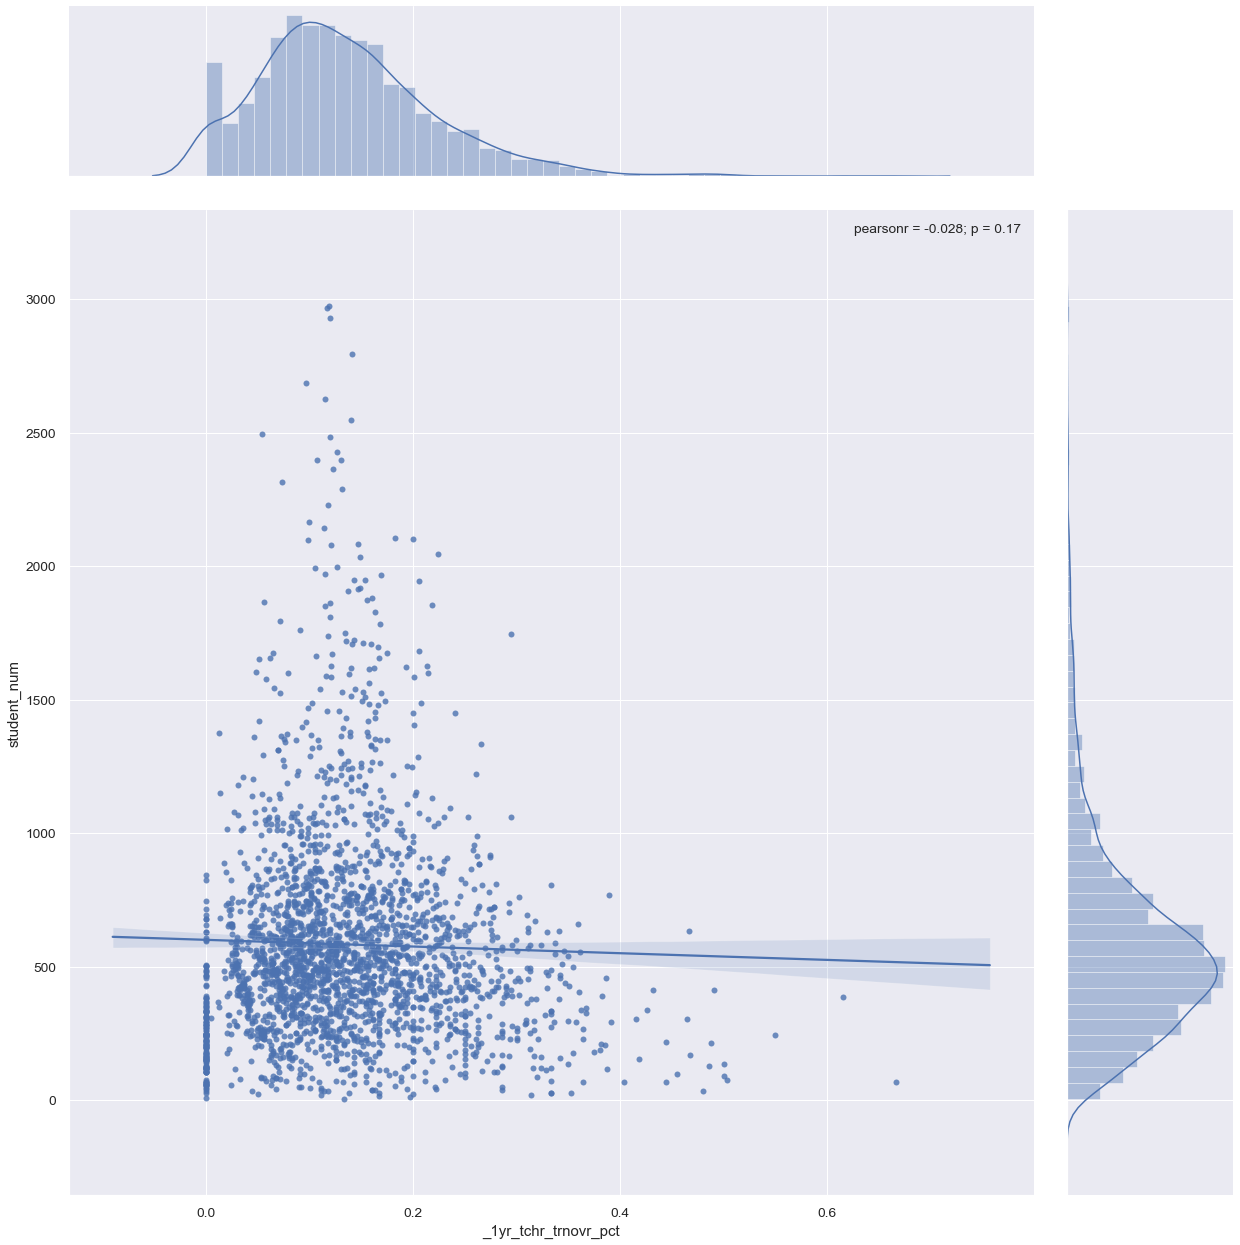

In [19]:
sns.set(context='notebook', style='darkgrid', font_scale=1.25)
my_plot = sns.jointplot(x='_1yr_tchr_trnovr_pct', y='student_num', data=data, kind="reg");
my_plot .annotate(stats.pearsonr)
my_plot.fig.set_figwidth(20)
my_plot.fig.set_figheight(20)
my_plot.savefig("_1yr_tchr_trnovr_pct_student_num_jointplot.png")

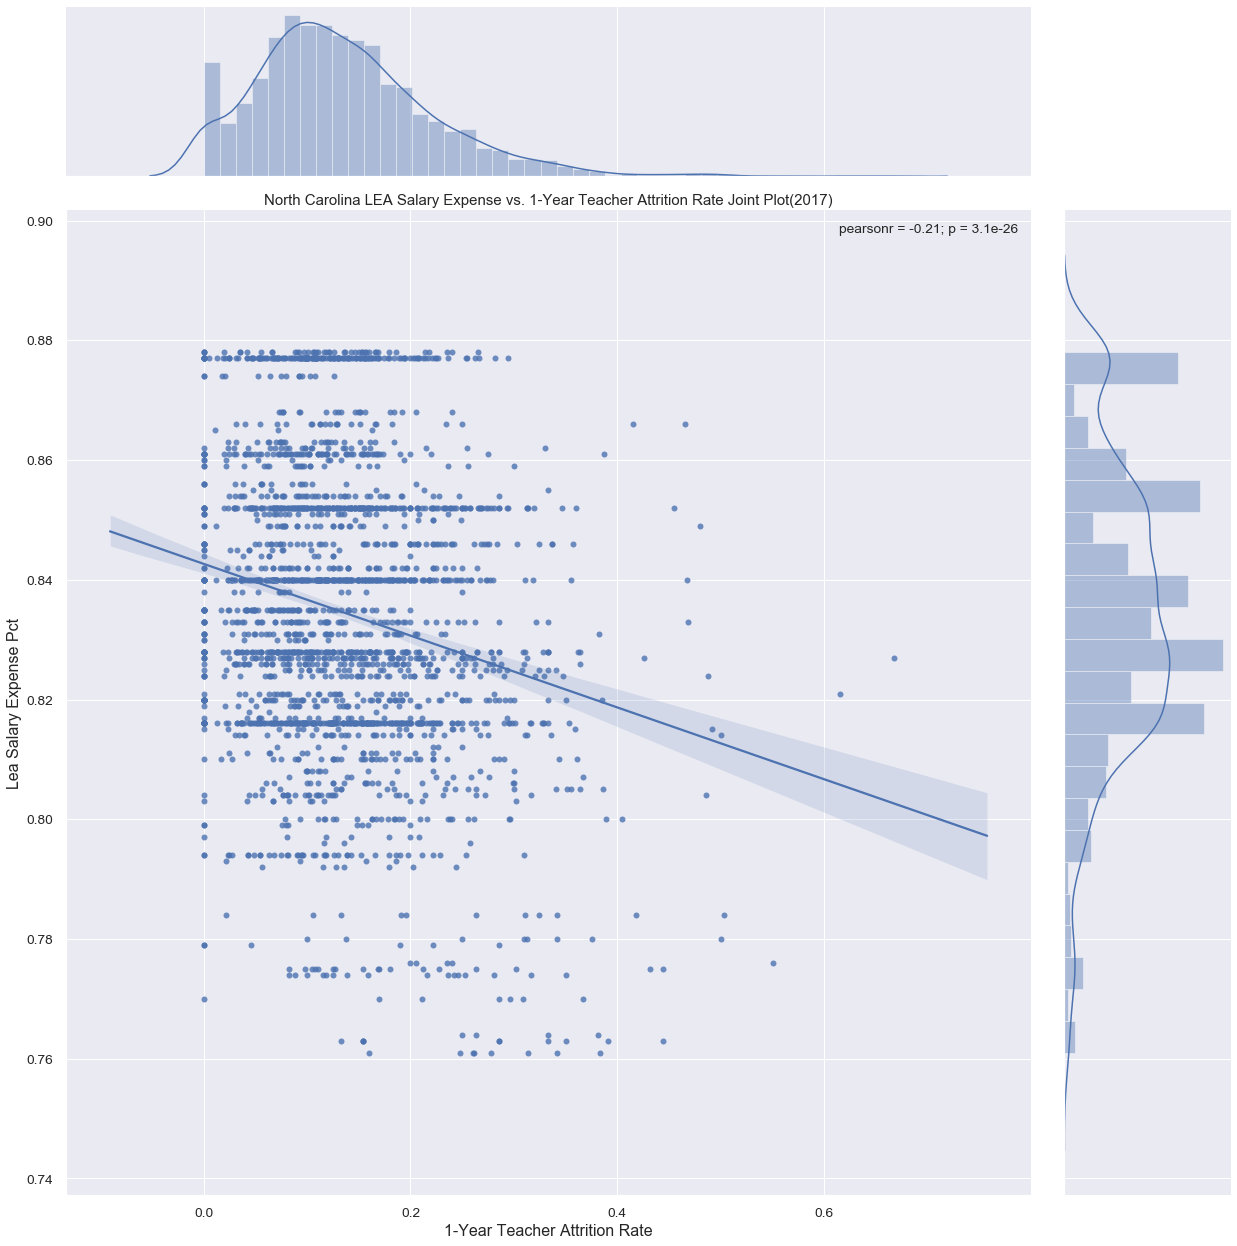

In [20]:
sns.set(context='notebook', style='darkgrid', font_scale=1.25)
my_plot = sns.jointplot(x='_1yr_tchr_trnovr_pct', y='lea_salary_expense_pct', data=data, kind="reg");
my_plot.annotate(stats.pearsonr)
my_plot.fig.set_figwidth(20)
my_plot.fig.set_figheight(20)
my_plot.set_axis_labels('1-Year Teacher Attrition Rate', 'Lea Salary Expense Pct', fontsize=16)
plt.title("North Carolina LEA Salary Expense vs. 1-Year Teacher Attrition Rate Joint Plot(2017)")
my_plot.savefig("_1yr_tchr_trnovr_pct_lea_salary_expense_pct.png")

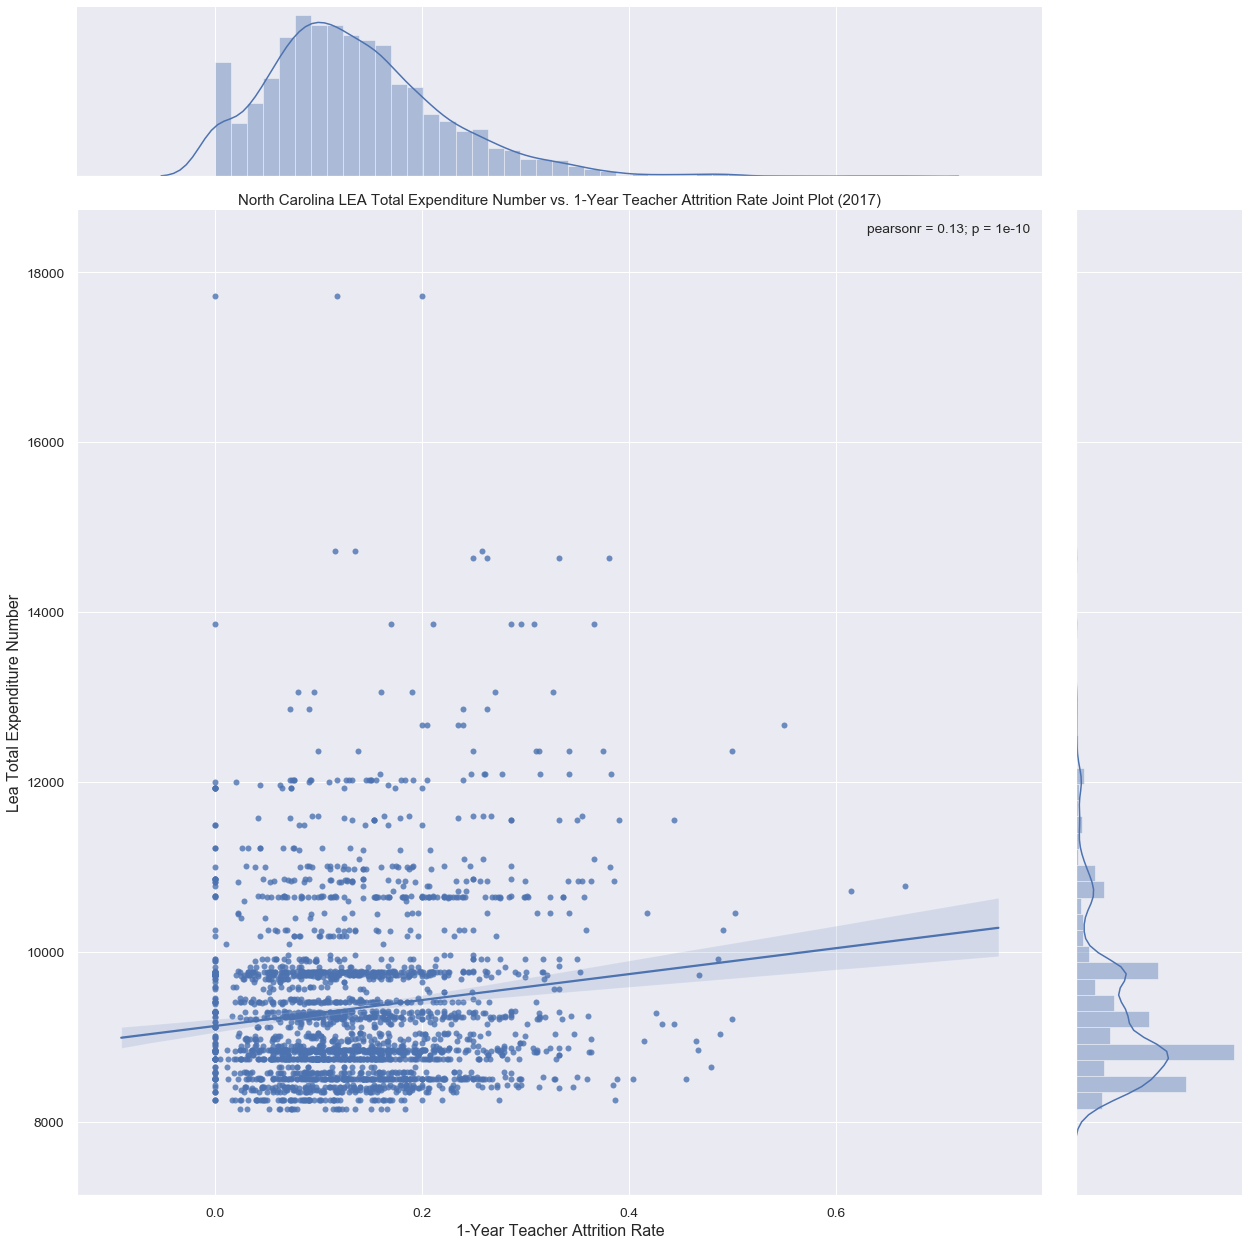

In [21]:
#sns.set(context='notebook', style='darkgrid', font_scale=1.25)
my_plot = sns.jointplot(x='_1yr_tchr_trnovr_pct', y='lea_total_expense_num', data=data, kind="reg");
my_plot.annotate(stats.pearsonr)
my_plot.fig.set_figwidth(20)
my_plot.fig.set_figheight(20)
my_plot.set_axis_labels('1-Year Teacher Attrition Rate', 'Lea Total Expenditure Number', fontsize=16)
plt.title("North Carolina LEA Total Expenditure Number vs. 1-Year Teacher Attrition Rate Joint Plot (2017)")
my_plot.savefig("_1yr_tchr_trnovr_pct_lea_total_expense_num.png")

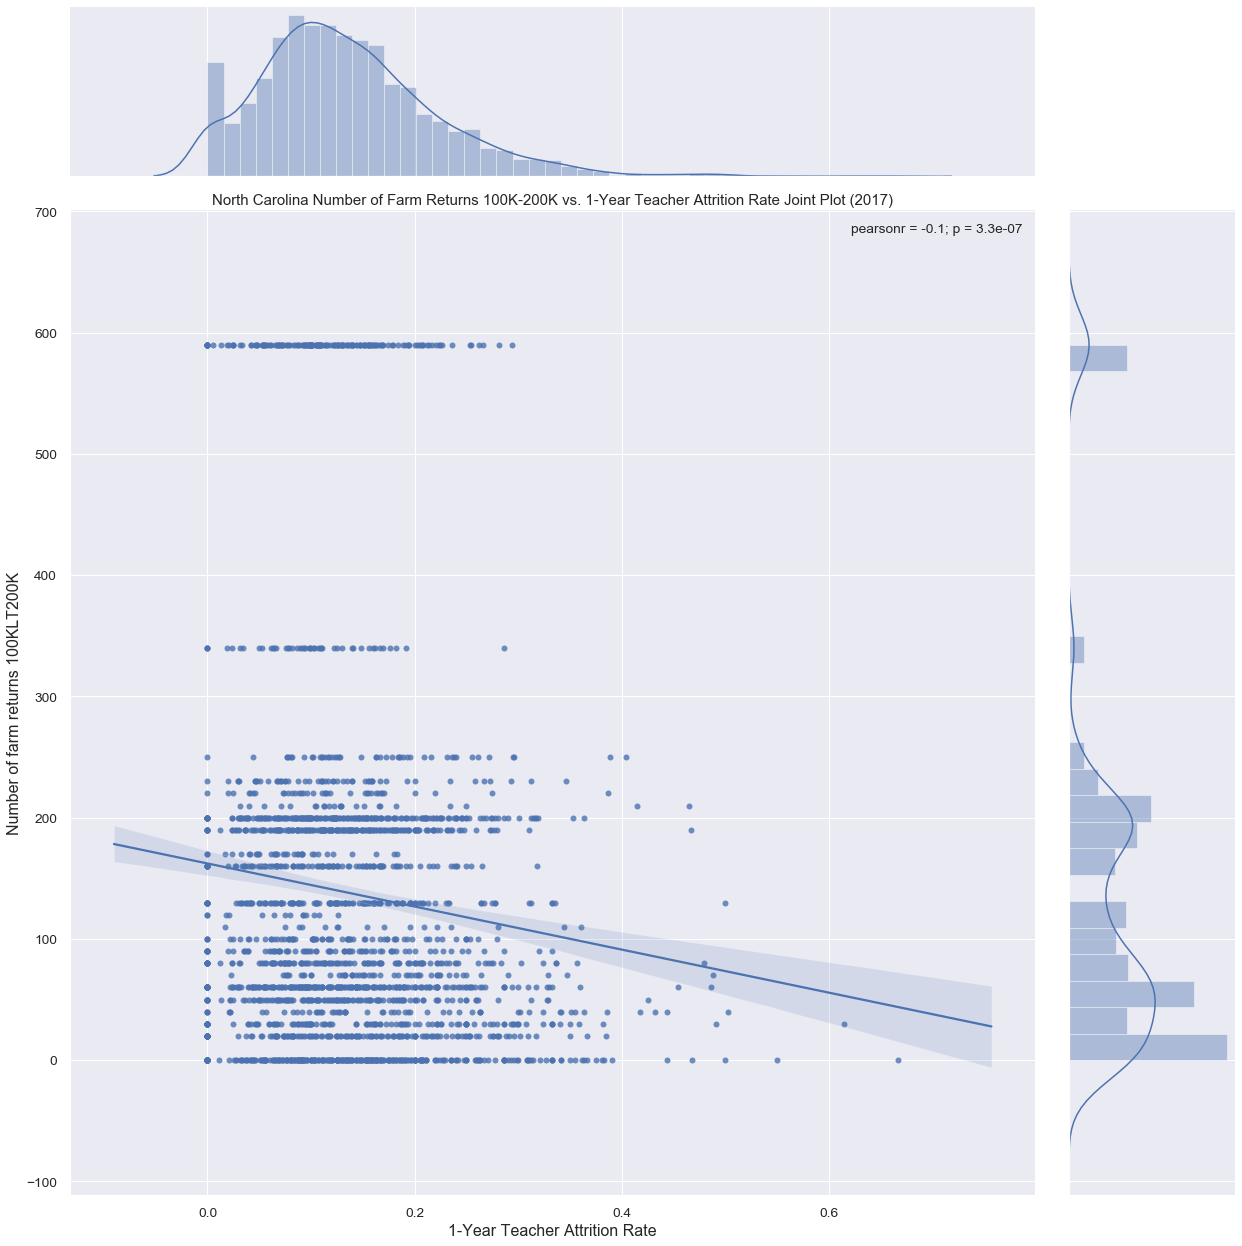

In [22]:
#sns.set(context='notebook', style='darkgrid', font_scale=1.25)
my_plot = sns.jointplot(x='_1yr_tchr_trnovr_pct', y='Number of farm returns 100KLT200K', data=data, kind="reg");
my_plot.annotate(stats.pearsonr)
my_plot.fig.set_figwidth(20)
my_plot.fig.set_figheight(20)
my_plot.set_axis_labels('1-Year Teacher Attrition Rate', 'Number of farm returns 100KLT200K', fontsize=16)
plt.title("North Carolina Number of Farm Returns 100K-200K vs. 1-Year Teacher Attrition Rate Joint Plot (2017)")
my_plot.savefig("_1yr_tchr_trnovr_pct_Number_of_farm_returns_100KLT200K.png")

In [23]:
#Create a function to plot regression lines for two variables
def PlotJoint(x,y,data):
    sns.set(context='notebook', style='darkgrid', font_scale=1.25)
    my_plot = sns.jointplot(x=x, y=y, data=data, kind="reg");
    my_plot .annotate(stats.pearsonr)
    my_plot.fig.set_figwidth(8)
    my_plot.fig.set_figheight(8)
   

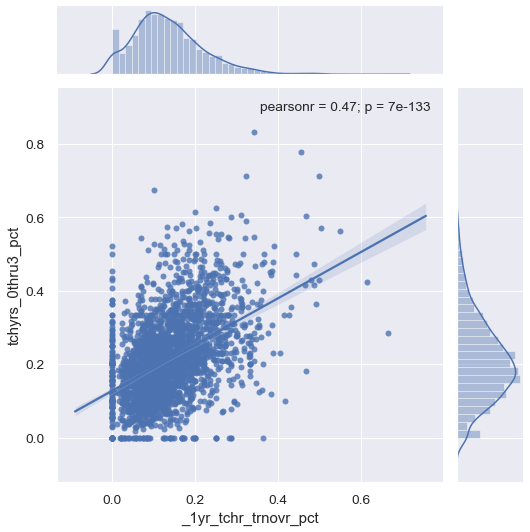

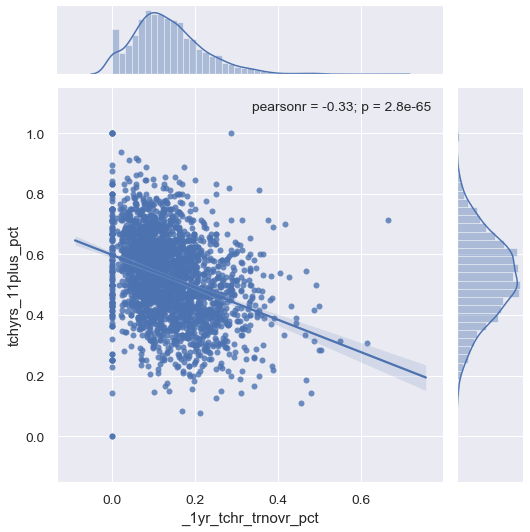

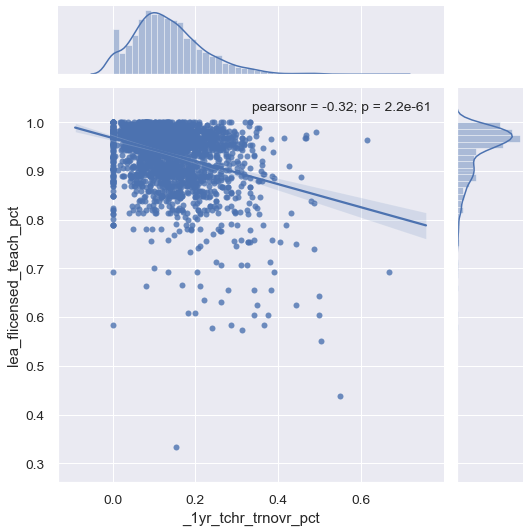

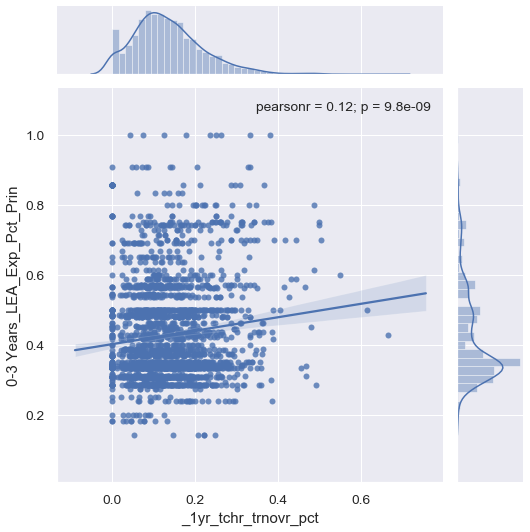

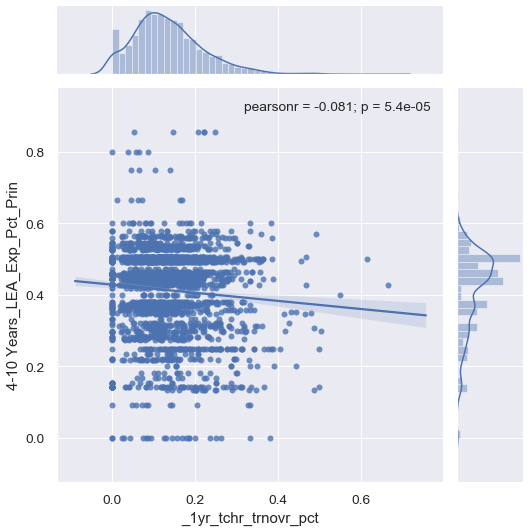

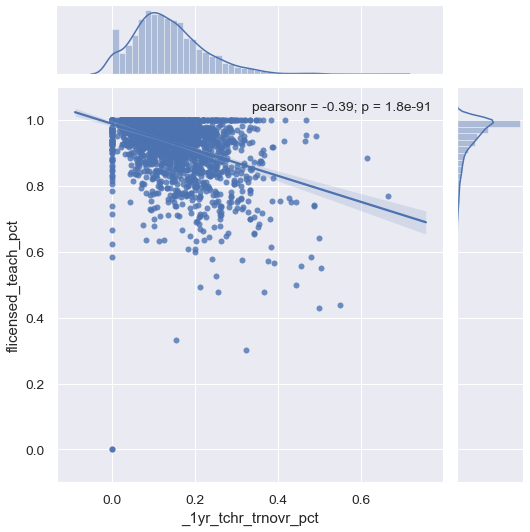

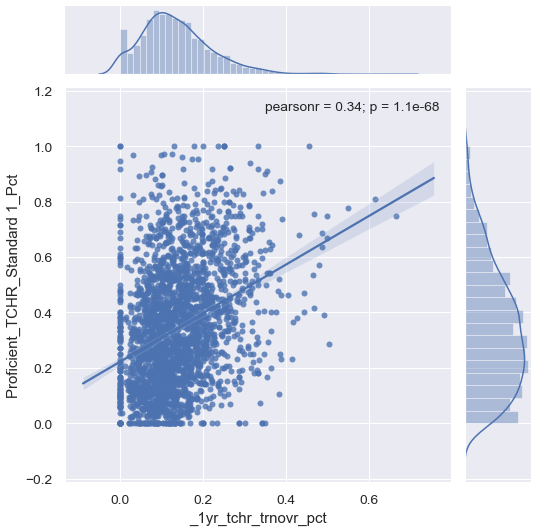

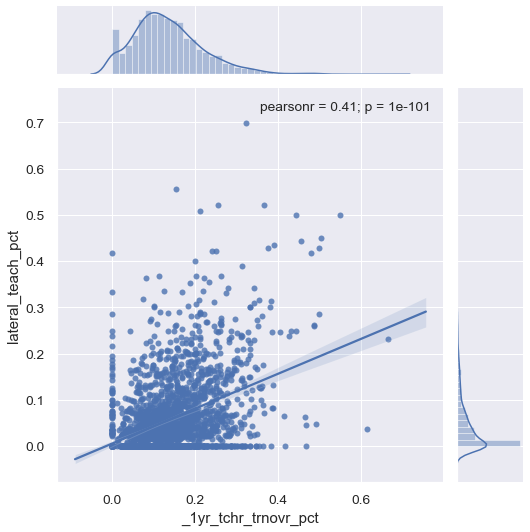

In [24]:
#Create district level charts to compare against teacher experience
teachprof = ['tchyrs_0thru3_pct','tchyrs_11plus_pct','lea_flicensed_teach_pct','0-3 Years_LEA_Exp_Pct_Prin','4-10 Years_LEA_Exp_Pct_Prin'
             ,'flicensed_teach_pct','Proficient_TCHR_Standard 1_Pct','lateral_teach_pct'
            ]

for col in teachprof:
    #print(col)
    try:
        PlotJoint(x='_1yr_tchr_trnovr_pct',y=col, data=schData)
        
    except Exception:
        print("Error")
        continue

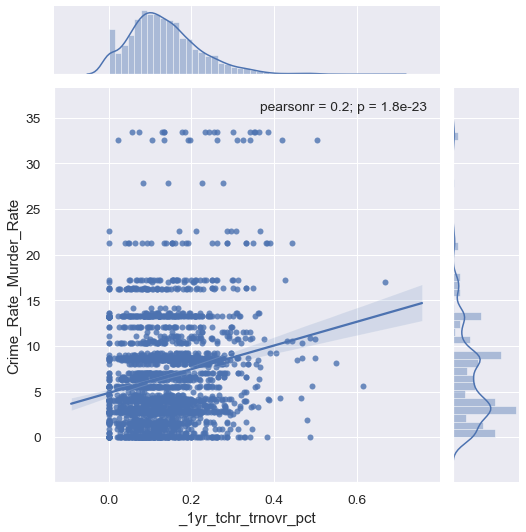

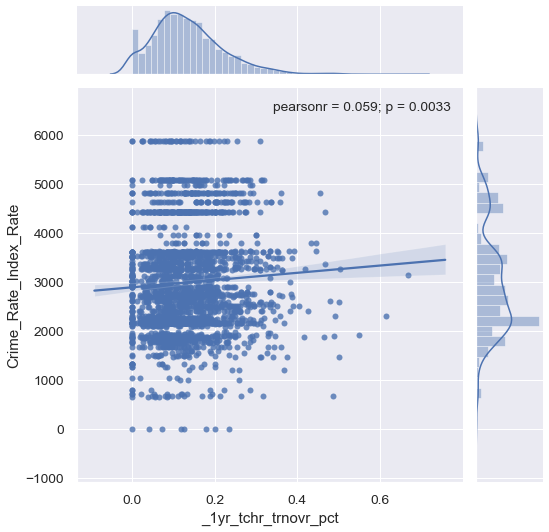

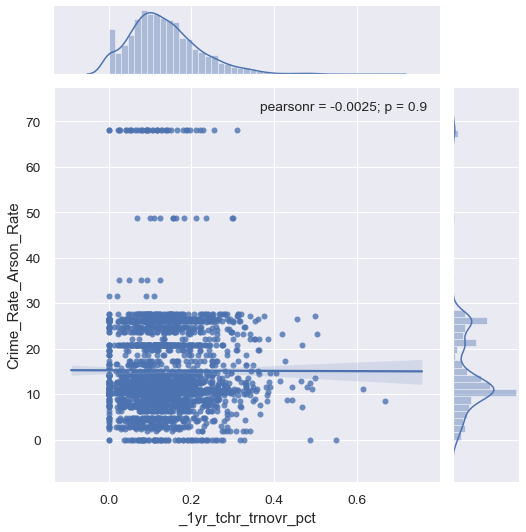

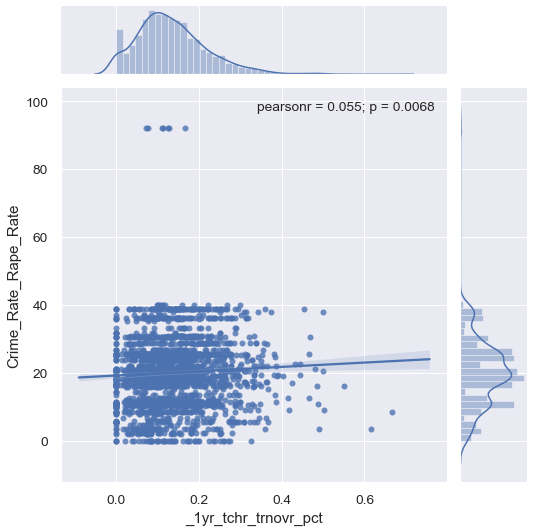

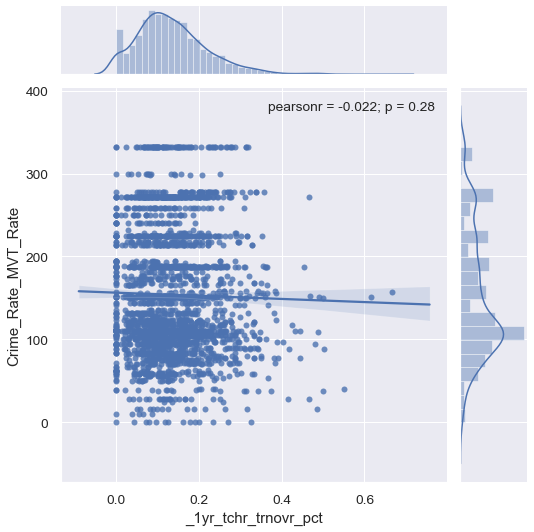

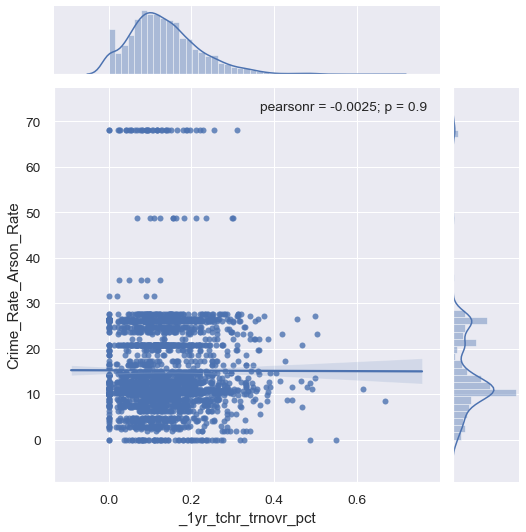

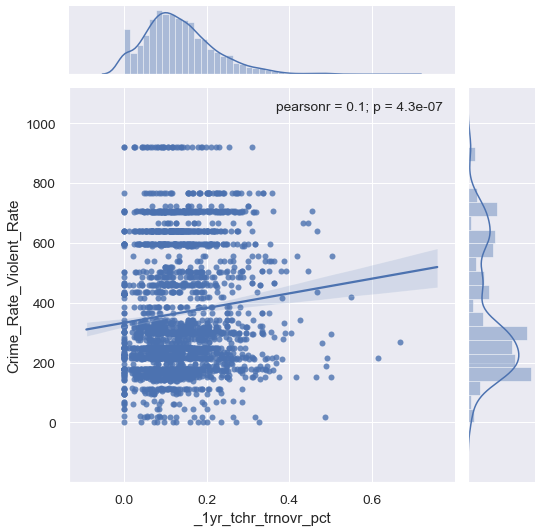

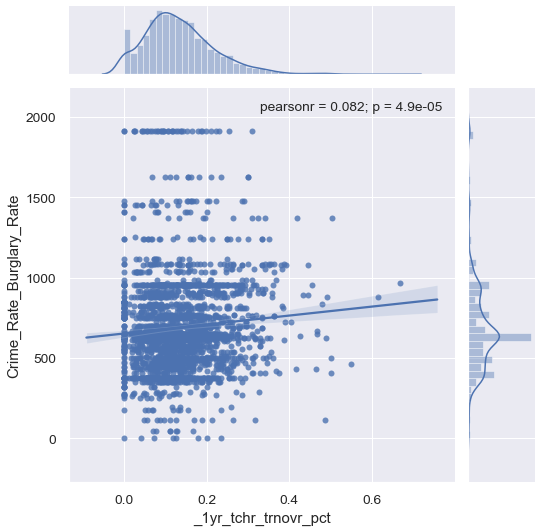

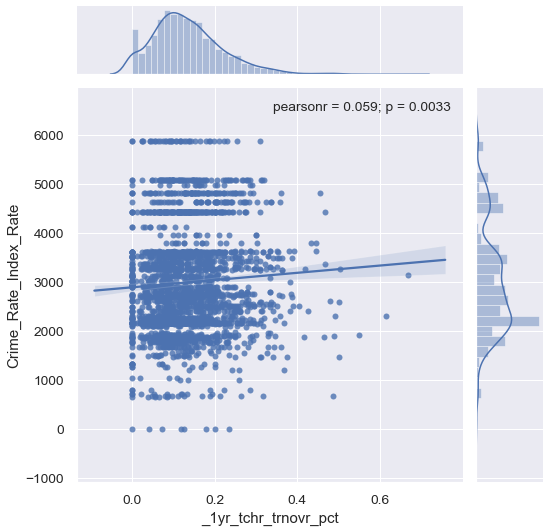

In [25]:
#Create district level charts to compare against Crime rate
teachprof = ['Crime_Rate_Murder_Rate','Crime_Rate_Index_Rate','Crime_Rate_Arson_Rate','Crime_Rate_Rape_Rate','Crime_Rate_MVT_Rate'
             ,'Crime_Rate_Arson_Rate','Crime_Rate_Violent_Rate','Crime_Rate_Burglary_Rate','Crime_Rate_Index_Rate'
            ]

for col in teachprof:
    #print(col)
    try:
        PlotJoint(x='_1yr_tchr_trnovr_pct',y=col, data=schData)
    except Exception:
        print("Error")
        continue

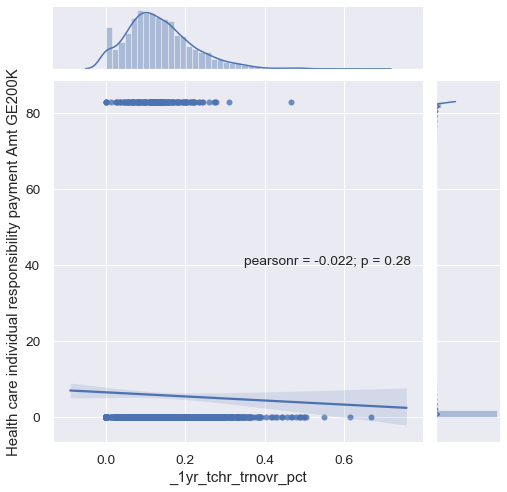

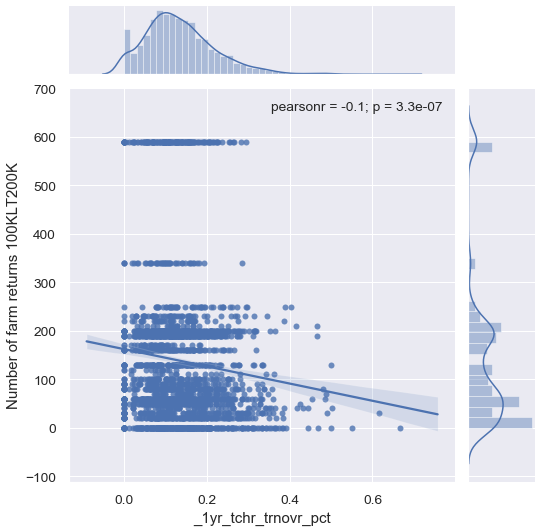

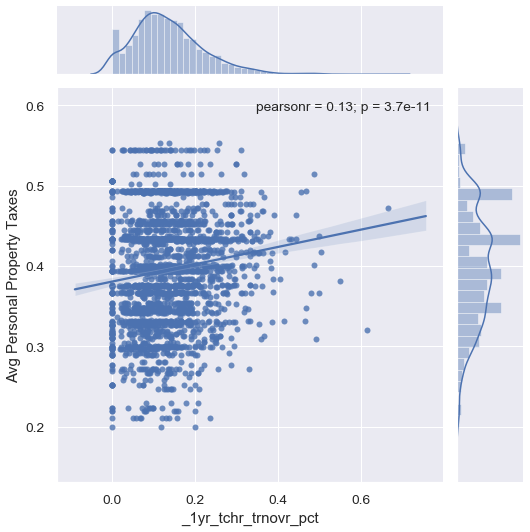

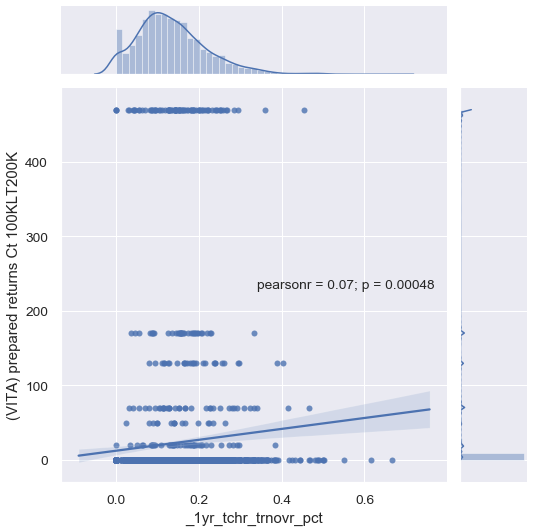

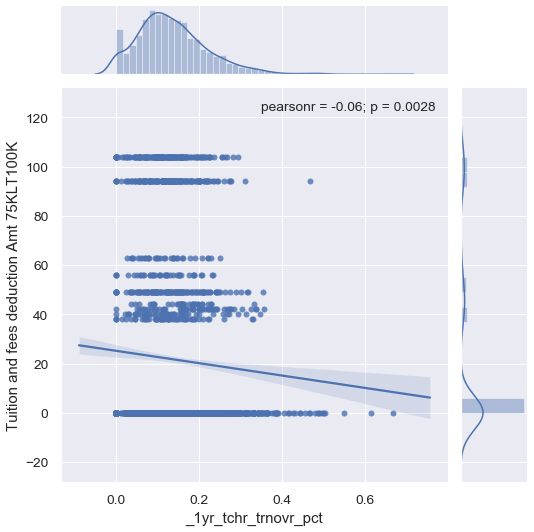

In [26]:
#Create district level charts to compare against income tax
teachprof = ['Health care individual responsibility payment Amt GE200K','Number of farm returns 100KLT200K',
             'Avg Personal Property Taxes','(VITA) prepared returns Ct 100KLT200K','Tuition and fees deduction Amt 75KLT100K'
            ]

for col in teachprof:
    #print(col)
    try:
        PlotJoint(x='_1yr_tchr_trnovr_pct',y=col, data=schData)
    except Exception:
        print("Error")
        continue

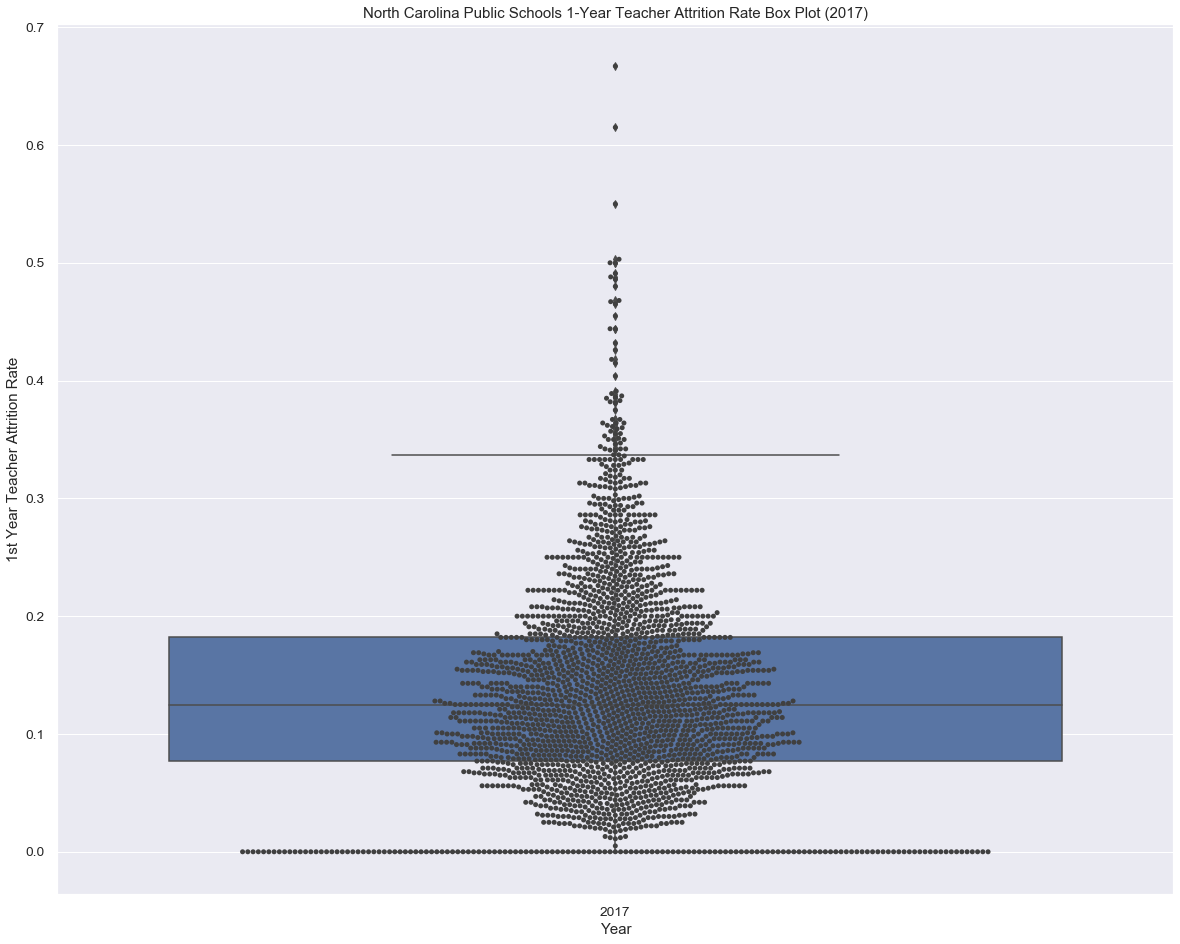

In [27]:
plt.figure(figsize=(20, 16))
ax = sns.boxplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData)
ax = sns.swarmplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData, color=".25")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Year')
plt.title("North Carolina Public Schools 1-Year Teacher Attrition Rate Box Plot (2017)")
plt.savefig('_1yr_tchr_trnovr_pct_boxplot.png')

## Feature Selection
* set max features we want to select

### Manually remove columns

* there columns is not what we are interested in, so we remove them manaually from data set

In [28]:
# manually remove the columns

ManualDropFeatures = ['st_1yr_tchr_trnovr_pct'
                      ,'lea_1yr_tchr_trnovr_pct'
                      #,'_1yr_tchr_trnovr_pct'
                     ,'PacificIslandPct','PacificIslandMalePct','PacificIslandFemalePct','HispanicPct'
                      ,'BlackPct','AsianPct','IndianPct','WhitePct','TwoOrMorePct','TwoOrMoreMalePct','TwoOrMoreFemalePct'

#                       ,'lea_supplies_expense_pct'
#                       ,'lea_services_expense_pct','lea_salary_expense_pct'
                      
                      
#                       ,'lea_total_expense_num'
#                       #,'lea_benefits_expense_pct'
#                       ,'lea_state_perpupil_num'
#                       ,'lea_local_perpupil_num'
#                       ,'lea_federal_perpupil_num'
                      
#                       ,'st_avg_student_num'
#                      ,'st_expelled_per_c_num'
#                      ,'st_crime_per_c_num'
#                      ,'st_avg_daily_attend_pct'
#                        ,'st_tchyrs_11plus_pct'
#                      ,'st_emer_prov_teach_pct'
#                      ,'st_long_susp_per_c_num'
#                      ,'st_flicensed_teach_pct'
#                      ,'st_short_susp_per_c_num'


                     ]

schData = schData.drop(ManualDropFeatures,axis=1)
print('*********After: Removing fetures we are not interested in ******')
schData.info(verbose=False)
print ('\r\nFeatures Deleted: ', len(ManualDropFeatures))

*********After: Removing fetures we are not interested in ******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 394 entries, student_num to unit_code
dtypes: float64(349), int64(45)
memory usage: 7.4 MB

Features Deleted:  13


In [29]:
# backup the data set
schData_bak = schData
schData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 394 entries, student_num to unit_code
dtypes: float64(349), int64(45)
memory usage: 7.4 MB


## Random shuffle the data

In [30]:
# some issue on the shuffle, disable it
from sklearn.utils import shuffle
schData = shuffle(schData)
schData.reset_index(inplace=True, drop=True) 

In [31]:
# Get the X and y
#y= schData['_1yr_tchr_trnovr_pct']
y= schData['_1yr_tchr_trnovr_pct']

#X = schData.drop(['_1yr_tchr_trnovr_pct'],axis=1)
X = schData.drop(['_1yr_tchr_trnovr_pct'],axis=1)
# save the header
saved_cols = X.columns

## Normalization


####  Normalizing the Data
* standardize data so that variance is 1 and mean is zero.

In [32]:
# credit: https://fatihsarigoz.com/scaling-rfe.html
# Transform

scaler = StandardScaler()
X_Stanardized = scaler.fit_transform(X)
#Save as data frames
X_Stanardized = pd.DataFrame(X_Stanardized)
X_Stanardized.columns = saved_cols

* rescale range to (0,1)

In [33]:
# # Rescale data (between 0 and 1)
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_reScaled =pd.DataFrame( scaler.fit_transform(X))
X_reScaled = pd.DataFrame(X_reScaled)
X_reScaled.columns = saved_cols

## Features Selection

In [34]:
# Credit https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/
# https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

# original credit: http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

from sklearn.linear_model import (LinearRegression, Ridge, Lasso,ElasticNet)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from minepy import MINE

np.random.seed(0)
size = 750
names = X.columns
ranks = {}
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

lr = LinearRegression(normalize=True)
lr.fit(X_Stanardized, y)
#ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
ranks["Linear reg"] = rank_to_dict(lr.coef_, names)

ridge = Ridge(alpha=7)
ridge.fit(X_Stanardized, y)
#ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
ranks["Ridge"] = rank_to_dict(ridge.coef_, names)

lasso = Lasso(alpha=.0001)
lasso.fit(X_reScaled, y)
#ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
ranks["Lasso"] = rank_to_dict(lasso.coef_, names)

elasticNet = ElasticNet(alpha=.0001)
elasticNet.fit(X_reScaled, y)
#ranks["ElasticNet"] = rank_to_dict(np.abs(ElasticNet.coef_), names)
ranks["ElasticNet"] = rank_to_dict(elasticNet.coef_, names)


# rlasso = RandomizedLasso(alpha=0.04)
# rlasso.fit(X, Y)
# ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)

#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X_Stanardized,y)
ranks["RFE"] = rank_to_dict(list(map(float, rfe.ranking_)), names, order=-1)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_Stanardized,y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)


f, pval = f_regression(X_Stanardized, y, center=True)
ranks["Corr."] = rank_to_dict(f, names)


mine = MINE(alpha=.05)
mic_scores = []
for i in range(X_Stanardized.shape[1]):
    #print(i)
    mine.compute_score(np.array(X_Stanardized)[:,i], y)
    m = mine.mic()
    mic_scores.append(m)
ranks["MIC"] = rank_to_dict(mic_scores, names) 
#print(ranks["MIC"])

r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

# print ("\t%s" % "\t".join(methods))
# for name in names:
#     print("%s\t%s" % (name, "\t".join(map(str,[ranks[method][name] for method in methods]))))
ranksDF = pd.DataFrame(ranks)
ranksDF.sort_values(by='Mean', inplace=True, ascending=False )
#ranksDF.columns = ['feature_names','Linear reg','Ridge','Lasso','ElasticNet','RFE','RF','Corr.','MIC','Mean']

ranksDF.to_csv("RFE_Feature_Importance_Results_2017.csv")

In [35]:
ranksDF.head(20)

Linear reg  Ridge  Lasso  \
tchyrs_0thru3_pct                                         0.42   1.00   1.00   
lateral_teach_pct                                         0.42   0.39   0.70   
Proficient_TCHR_Standard 1_Pct                            0.42   0.53   0.52   
tchyrs_11plus_pct                                         0.42   0.77   0.30   
flicensed_teach_pct                                       0.42   0.23   0.33   
Developing_TCHR_Standard 4_Pct                            0.42   0.48   0.60   
Crime_Rate_Murder_Rate                                    0.42   0.63   0.55   
Attrition_Reason_OtherReasonsPerct                        0.42   0.48   0.52   
st_avg_student_num                                        1.00   0.43   0.33   
EOG/EOCSubjects_CACR_AIG                                  0.42   0.69   0.38   
Proficient_TCHR_Standard 2_Pct                            0.42   0.45   0.33   
Accomplished_TCHR_Standard 2_Pct                          0.42   0.48   0.36   
Proficient_TCHR_Standard 3_Pct                            0.42   0.40   0.33   
Health care individual responsibility payment A...        0.42   0.92   0.33   
lea_services_expense_pct                                  0.27   0.55   0.41   
lea_tchyrs_0thru3_pct                                     0.42   0.45   0.47   
Developing_TCHR_Standard 2_Pct                            0.42   0.47   0.39   
Accomplished_TCHR_Standard 3_Pct                          0.42   0.40   0.33   
Accomplished_TCHR_Standard 4_Pct                          0.42   0.41   0.33   
Accomplished_TCHR_Standard 5_Pct                          0.42   0.44   0.33   

                                                    ElasticNet   RFE    RF  \
tchyrs_0thru3_pct                                         1.00  0.90  1.00   
lateral_teach_pct                                         0.63  0.77  0.08   
Proficient_TCHR_Standard 1_Pct                            0.54  0.85  0.10   
tchyrs_11plus_pct                                         0.31  0.85  0.06   
flicensed_teach_pct                                       0.22  0.85  0.21   
Developing_TCHR_Standard 4_Pct                            0.60  0.63  0.03   
Crime_Rate_Murder_Rate                                    0.63  0.76  0.01   
Attrition_Reason_OtherReasonsPerct                        0.48  0.84  0.07   
st_avg_student_num                                        0.31  0.98  0.00   
EOG/EOCSubjects_CACR_AIG                                  0.50  0.80  0.02   
Proficient_TCHR_Standard 2_Pct                            0.31  0.89  0.03   
Accomplished_TCHR_Standard 2_Pct                          0.37  0.89  0.03   
Proficient_TCHR_Standard 3_Pct                            0.31  0.87  0.03   
Health care individual responsibility payment A...        0.44  0.86  0.00   
lea_services_expense_pct                                  0.43  1.00  0.03   
lea_tchyrs_0thru3_pct                                     0.46  0.33  0.11   
Developing_TCHR_Standard 2_Pct                            0.39  0.77  0.02   
Accomplished_TCHR_Standard 3_Pct                          0.31  0.87  0.03   
Accomplished_TCHR_Standard 4_Pct                          0.31  0.61  0.04   
Accomplished_TCHR_Standard 5_Pct                          0.31  0.88  0.03   

                                                    Corr.   MIC  Mean  
tchyrs_0thru3_pct                                    1.00  1.00  0.92  
lateral_teach_pct                                    0.74  0.63  0.55  
Proficient_TCHR_Standard 1_Pct                       0.48  0.49  0.49  
tchyrs_11plus_pct                                    0.45  0.52  0.46  
flicensed_teach_pct                                  0.66  0.69  0.45  
Developing_TCHR_Standard 4_Pct                       0.32  0.31  0.42  
Crime_Rate_Murder_Rate                               0.15  0.14  0.41  
Attrition_Reason_OtherReasonsPerct                   0.16  0.24  0.40  
st_avg_student_num                                   0.01  0.11  0.40  
EOG/EOCSubje

In [36]:
ranksDF['Mean'].describe()

count    392.000000
mean       0.272883
std        0.063734
min        0.120000
25%        0.230000
50%        0.260000
75%        0.310000
max        0.920000
Name: Mean, dtype: float64

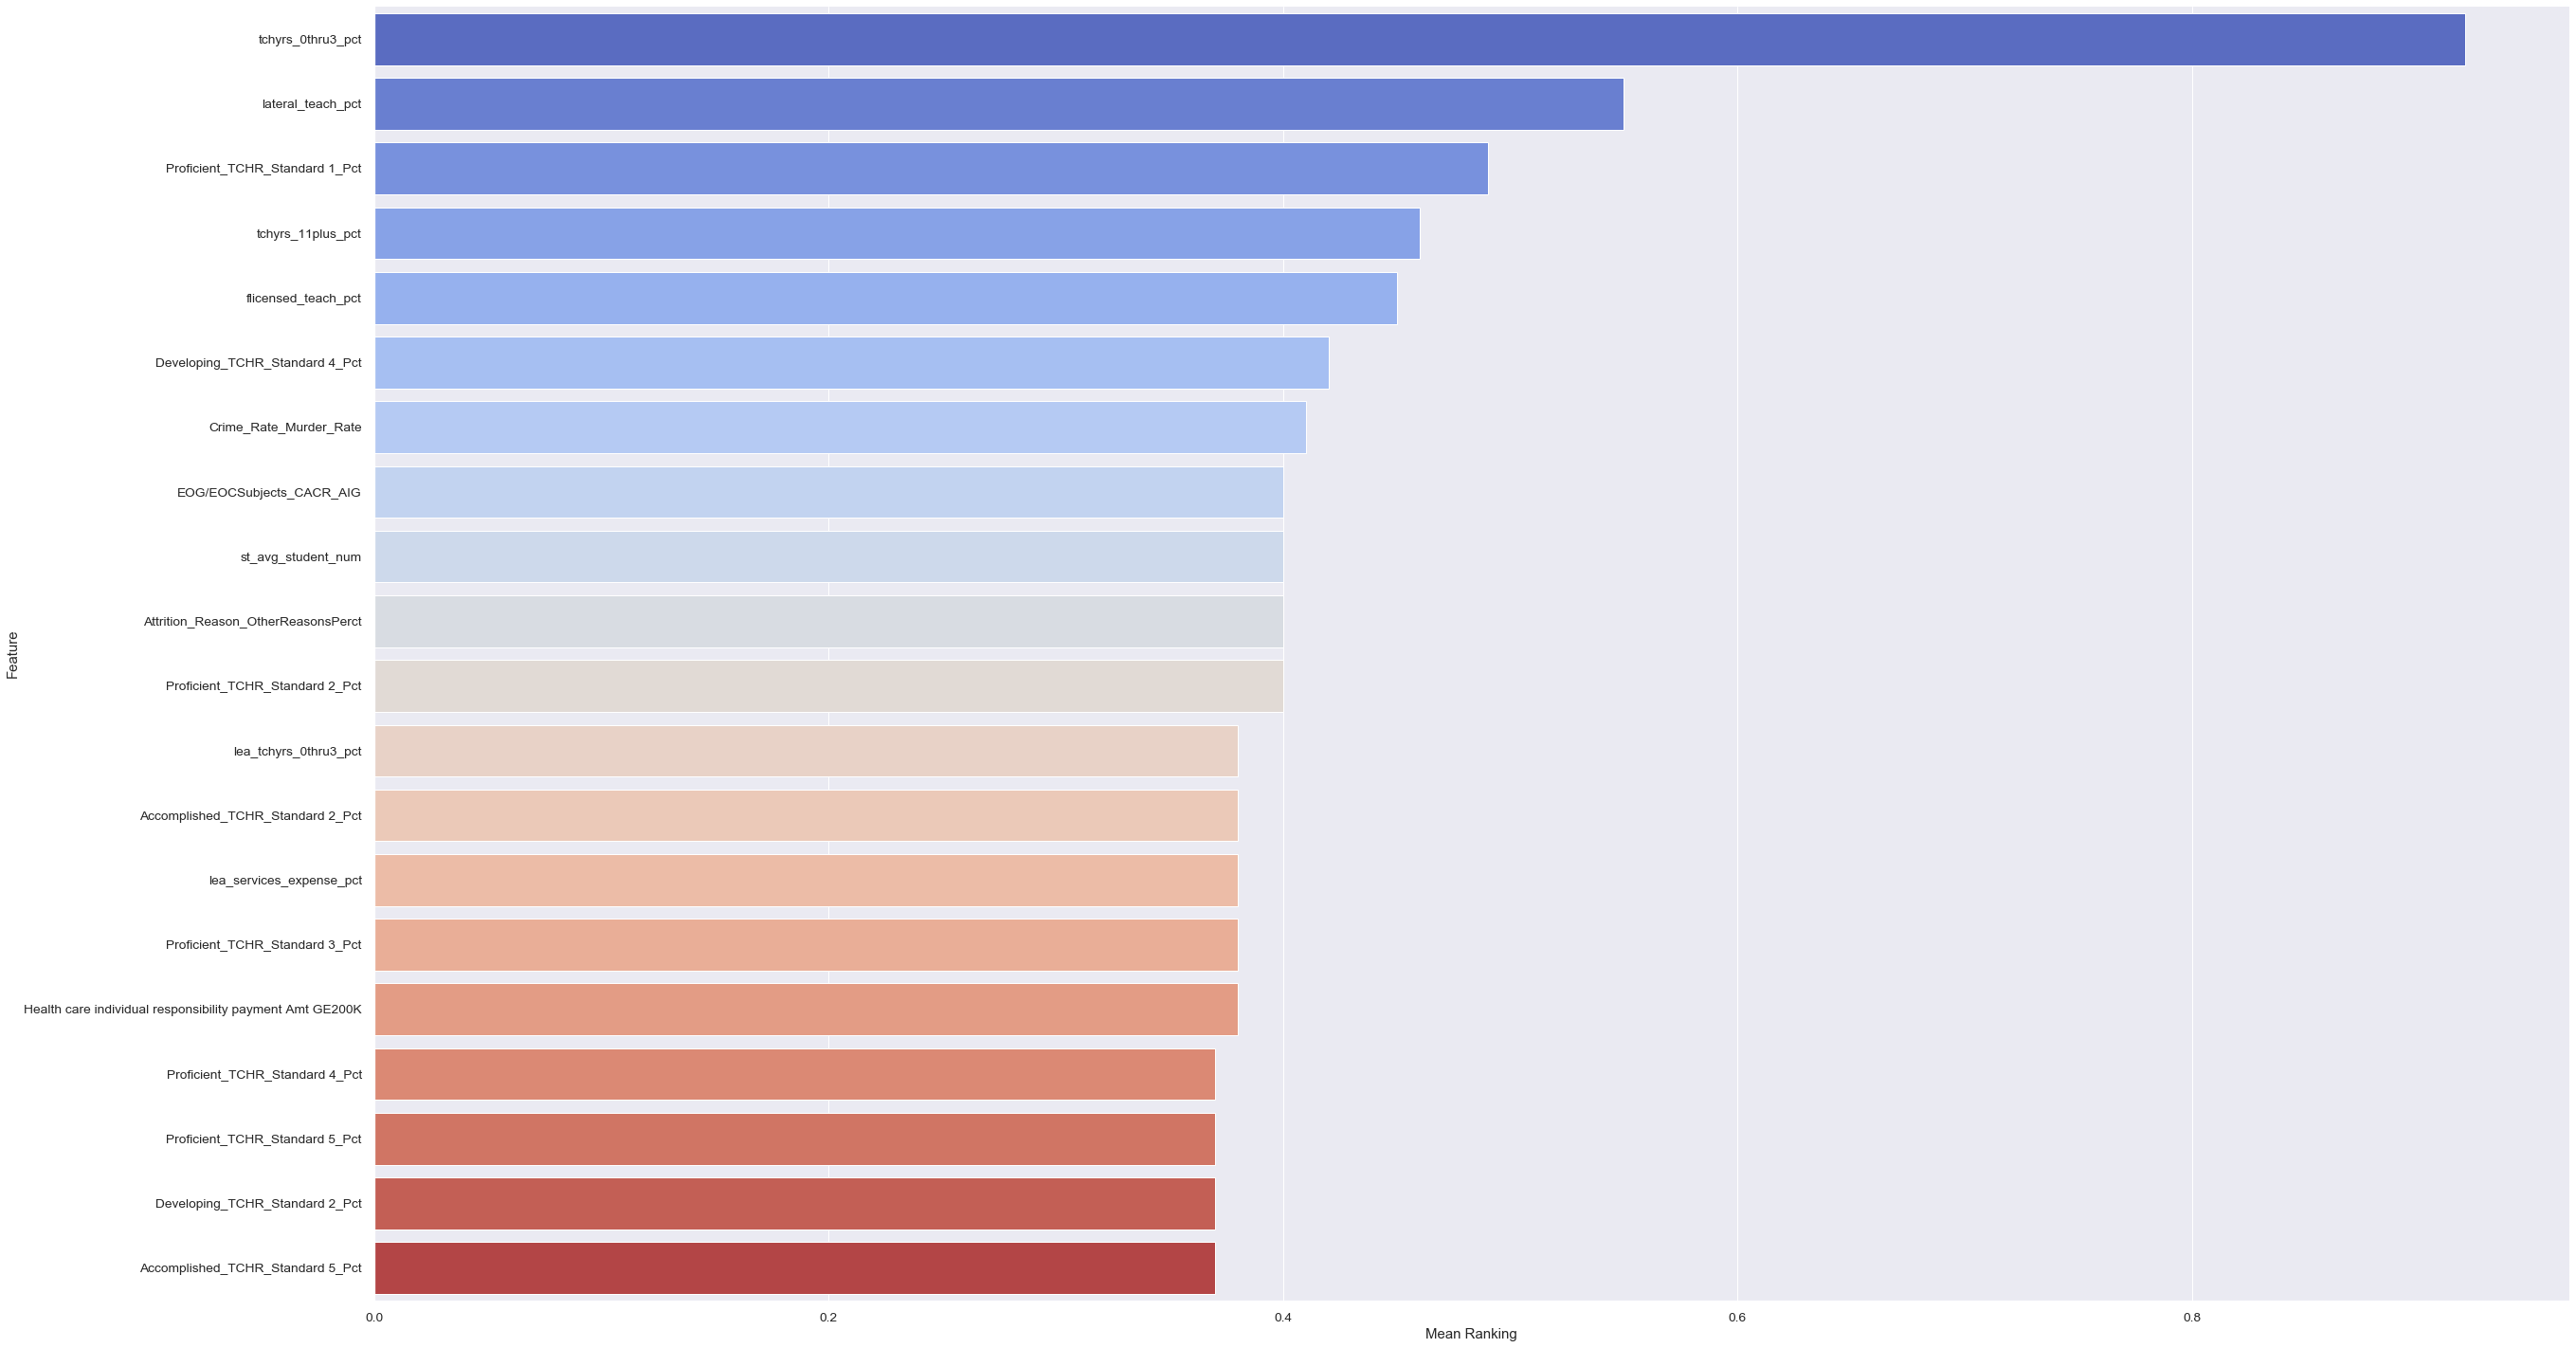

In [37]:
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
meanplotTop50 = meanplot[0:20]
# Let's plot the ranking of the features
sns.catplot(x="Mean Ranking", y="Feature", data = meanplotTop50, kind="bar", 
               height=20, aspect=1.9, palette='coolwarm')

In [38]:
feature_to_remove = ranksDF[ranksDF['Mean']<=ranksDF['Mean'].mean()-ranksDF['Mean'].std()].index
#feature_to_remove = ranksDF[ranksDF['Mean']<=ranksDF['Mean'].mean()].index
X_Stanardized = X_Stanardized.drop(feature_to_remove, axis=1)

#feature_to_remove
print ('\r\nFeatures Deleted: ', len(feature_to_remove))


Features Deleted:  30


In [39]:
feature_to_remove

Index(['EOGScienceGr5&8_GLP_LEP', 'EOGReadingGr5_GLP_LEP',
       'EOCMathI_CACR_Asian', 'EOGReadingGr3-8_CACR_AmericanIndian',
       'EOCMathI_CACR_AmericanIndian', 'EOCMathI_GLP_SWD', 'EOGGr5_CACR_Black',
       'EOGScienceGr5&8_CACR_TwoorMoreRaces', 'EOGScienceGr5&8_CACR_LEP',
       'EOGMathGr3_CACR_TwoorMoreRaces', 'EOGMathGr4_CACR_TwoorMoreRaces',
       'Home mortgage interest paid from personal seller Amt LT25K',
       'EOGReadingGr4_GLP_LEP', 'EOGGr3_CACR_TwoorMoreRaces',
       'lea_expelled_per_c_num', 'lea_emer_prov_teach_pct',
       'EOGReadingGr3_CACR_Hispanic', 'EOGGr5_CACR_Asian', 'EOCMathI_CACR_EDS',
       'Not Demostrated_TCHR_Standard 2_Pct',
       'EOGReadingGr3_CACR_AmericanIndian',
       'calendar_type_txt_Vocational Education, Traditional Calendar',
       'EOGScienceGr5_CACR_AmericanIndian', 'EOGReadingGr5_CACR_LEP',
       'EOGGr4_CACR_AmericanIndian', 'EOGGr5_CACR_AmericanIndian',
       'EOGReadingGr4_CACR_LEP', 'Avg Dependents Per Ret',
       'Pct of 

In [40]:
X_Stanardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 363 entries, student_num to unit_code
dtypes: float64(363)
memory usage: 6.8 MB


## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [41]:
#Divide data into test and training splits
#from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=12)

X_train, X_test, y_train, y_test = train_test_split(X_Stanardized, y, test_size=0.2,random_state =42)
print("Training set", X_train.shape, y_train.shape)
print("Test set", X_test.shape, y_test.shape)


Training set (1974, 363) (1974,)
Test set (494, 363) (494,)


## Regression Models Evaluation

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
* R Square (R^2)

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer


** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [42]:
# it may not make sense to use MAPE in our project based on below articles:
# http://www.catchbull.com/catchblogs/why-mape-doesnt-work

In [43]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score 
from ml_metrics import rmse


#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
# def rmse(y_actual, y_predicted):
#     return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
# revised from - https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
# still not working
def mape(y_actual, y_predicted): 
    mask = y_actual != 0 
    #print(y_actual)
#     print(y_predicted)
#     return (np.abs(y_actual - y_predicted)/y_actual)[mask].mean() * 100
    y_actual, y_pred = np.array(y_actual), np.array(y_predicted)
    return np.mean(np.abs((y_actual - y_pred) / y_actual))/len(y_actual) * 100
    
#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(score_func=mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True) 

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'MSE':  mse_scorer, 
                'RMSE': rmse_scorer,
               # 'MAPE': mape_scorer,
                'R2': r2_scorer       
               } 

In [44]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #print(scores)
    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MSE'] = scores['test_MSE'] * -1
#     scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1
    scores['test_R2'] = scores['test_R2'] 

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

     #print mean MAE for all folds 
    mseAvg = scores['test_MSE'].mean()
    print_str = "The average MSE for all cv folds is: \t\t\t {mseAvg:.5}"
    print(print_str.format(mseAvg=mseAvg))
    
#     #print mean test_MAPE for all folds
#     scores['test_MAPE'] = scores['test_MAPE']
#     mape_avg = scores['test_MAPE'].mean()
#     print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
#     print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')
    
    #print mean R-squared for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R-Squared for all cv folds is: \t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('*********************************************************')


    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MSE'] = scores['test_MSE']
    #scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    return scoresResults


## Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with graduation rate predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [45]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):
    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [46]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = LinearRegression()
parameters = {'copy_X':(True,False), 'fit_intercept':(True,False),'normalize': (True, False)}

linregGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
linregGridSearch.fit(X_Stanardized, y)
linregEstimator =linregGridSearch.best_estimator_
Linear_Results = EvaluateRegressionEstimator(linregEstimator, X_Stanardized, y, cv)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:    2.7s finished


The average MAE for all cv folds is: 			 0.058203
The average MSE for all cv folds is: 			 0.0062949
The average RMSE for all cv folds is: 			 0.078618
*********************************************************
The average R-Squared for all cv folds is: 		 0.16578
*********************************************************
Cross Validation Fold Mean Error Scores


## Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [47]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
svr = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
costs = [0.001, 0.1]
defGamma = 1 / X_Stanardized.shape[1]  #This is the default value for the gamma parameter
gammas = [defGamma, 0.1]
kernels = [ 'linear', 'rbf']
parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
svrGridSearch = GridSearchCV(estimator=svr
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
svrGridSearch.fit(X_Stanardized, y)
svrEstimator =svrGridSearch.best_estimator_
SVR_Results = EvaluateRegressionEstimator(svrEstimator, X_Stanardized, y, cv)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:   23.4s finished


The average MAE for all cv folds is: 			 0.057994
The average MSE for all cv folds is: 			 0.0056977
The average RMSE for all cv folds is: 			 0.075426
*********************************************************
The average R-Squared for all cv folds is: 		 0.2424
*********************************************************
Cross Validation Fold Mean Error Scores


## Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [48]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

lasso = Lasso()

#Test parameters 
alpha = [0.0001,0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
fit_intercept = [True, False]
normalize = [True, False]
copy_X = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start
              ,'fit_intercept':fit_intercept,'normalize':normalize,'copy_X': copy_X}

#Create a grid search object using the parameters above
lassoGridSearch = GridSearchCV(estimator=lasso
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
lassoGridSearch.fit(X_Stanardized, y)
#Create a regression estimator with best parameters for cross validation
lassoEstimator =lassoGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Lasso_Results = EvaluateRegressionEstimator(lassoEstimator, X_Stanardized, y, cv)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done 268 tasks      | elapsed:   40.8s
[Parallel(n_jobs=8)]: Done 673 tasks      | elapsed:   58.4s
[Parallel(n_jobs=8)]: Done 1905 out of 1920 | elapsed:  1.1min remaining:    0.4s
[Parallel(n_jobs=8)]: Done 1920 out of 1920 | elapsed:  1.1min finished


The average MAE for all cv folds is: 			 0.054731
The average MSE for all cv folds is: 			 0.0052429
The average RMSE for all cv folds is: 			 0.07233
*********************************************************
The average R-Squared for all cv folds is: 		 0.30417
*********************************************************
Cross Validation Fold Mean Error Scores


## Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [49]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

ridge = Ridge()

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg']#, 'sag']#, 'saga']
parameters = {'alpha': alpha, 'solver': solver}
#parameters = {'alpha': alpha}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
ridgeGridSearch = GridSearchCV(estimator=ridge
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
ridgeGridSearch.fit(X_Stanardized, y)
#Create a regression estimator with best parameters for cross validation
ridgeEstimator = ridgeGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Ridge_Results = EvaluateRegressionEstimator(ridgeEstimator, X_Stanardized, y, cv)


Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:    9.5s finished


The average MAE for all cv folds is: 			 0.056689
The average MSE for all cv folds is: 			 0.005564
The average RMSE for all cv folds is: 			 0.074544
*********************************************************
The average R-Squared for all cv folds is: 		 0.25932
*********************************************************
Cross Validation Fold Mean Error Scores


## Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [50]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
elasticNetGridSearch = GridSearchCV(estimator=elasticNet
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
elasticNetGridSearch.fit(X_Stanardized, y)
#Create a regression estimator with best parameters for cross validation
elasticNetEstimator = elasticNetGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
elastic_Results = EvaluateRegressionEstimator(elasticNetEstimator, X_Stanardized, y, cv)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:    7.5s finished


The average MAE for all cv folds is: 			 0.056096
The average MSE for all cv folds is: 			 0.0054007
The average RMSE for all cv folds is: 			 0.073383
*********************************************************
The average R-Squared for all cv folds is: 		 0.28422
*********************************************************
Cross Validation Fold Mean Error Scores


### Model Comparison

In [117]:
modelCompare = pd.DataFrame(columns=['EstimatorName','BestEstimator','MAE','MSE','RMSE'])
modelCompare.loc[0] = ['LinearRegression',linregEstimator,Linear_Results['MAE'].mean(),Linear_Results['MSE'].mean(),Linear_Results['RMSE'].mean()]
modelCompare.loc[1] = ['SVR',linregEstimator,SVR_Results['MAE'].mean(),SVR_Results['MSE'].mean(),SVR_Results['RMSE'].mean()]
modelCompare.loc[2] = ['Lasso',lassoEstimator,Lasso_Results['MAE'].mean(),Lasso_Results['MSE'].mean(),Lasso_Results['RMSE'].mean()]
modelCompare.loc[3] = ['Ridge',ridgeEstimator,Ridge_Results['MAE'].mean(),Ridge_Results['MSE'].mean(),Ridge_Results['RMSE'].mean()]
modelCompare.loc[4] = ['ElasticNet',elasticNetEstimator,elastic_Results['MAE'].mean(),elastic_Results['MSE'].mean(),elastic_Results['RMSE'].mean()]


In [52]:
# modelCompare = modelCompare.sort_values(by='MAE', ascending=True)
# modelCompare

EstimatorName                                      BestEstimator  \
2             Lasso  Lasso(alpha=0.001, copy_X=True, fit_intercept=...   
4        ElasticNet  ElasticNet(alpha=0.001, copy_X=True, fit_inter...   
3             Ridge  Ridge(alpha=20, copy_X=True, fit_intercept=Tru...   
1               SVR  LinearRegression(copy_X=True, fit_intercept=Tr...   
0  LinearRegression  LinearRegression(copy_X=True, fit_intercept=Tr...   

        MAE       MSE      RMSE  
2  0.054731  0.005243  0.072330  
4  0.056096  0.005401  0.073383  
3  0.056689  0.005564  0.074544  
1  0.057994  0.005698  0.075426  
0  0.058203  0.006295  0.078618

In [53]:
print("The best model is:")
print("Model Name: ",modelCompare.iloc[0]['EstimatorName'])
print("Model: ",modelCompare.iloc[0]['BestEstimator'])
print("MAE: ",modelCompare.iloc[0]['MAE'])
print("MSE: ",modelCompare.iloc[0]['MSE'])
print("RMSE: ",modelCompare.iloc[0]['RMSE'])

The best model is:
Model Name:  Lasso
Model:  Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=True)
MAE:  0.054730812308916
MSE:  0.005242888618644528
RMSE:  0.07232997104571806


In [54]:

bestEstimator =  modelCompare.iloc[0]['BestEstimator']

bestEstimator = bestEstimator.fit(X_train, y_train)
yhat = bestEstimator.predict(X_test)
print("Yhat Min: ", yhat.min(),"Yhat Max: ", yhat.max(),"Yhat Mean: ", yhat.mean(),"Yhat Std: ", yhat.std())
print("Explained variance Score:%.2f"%(explained_variance_score(y_test,yhat, multioutput='uniform_average')))

Yhat Min:  0.036696948312833114 Yhat Max:  0.3080669313307996 Yhat Mean:  0.135288074270341 Yhat Std:  0.04574778450881024
Explained variance Score:0.24


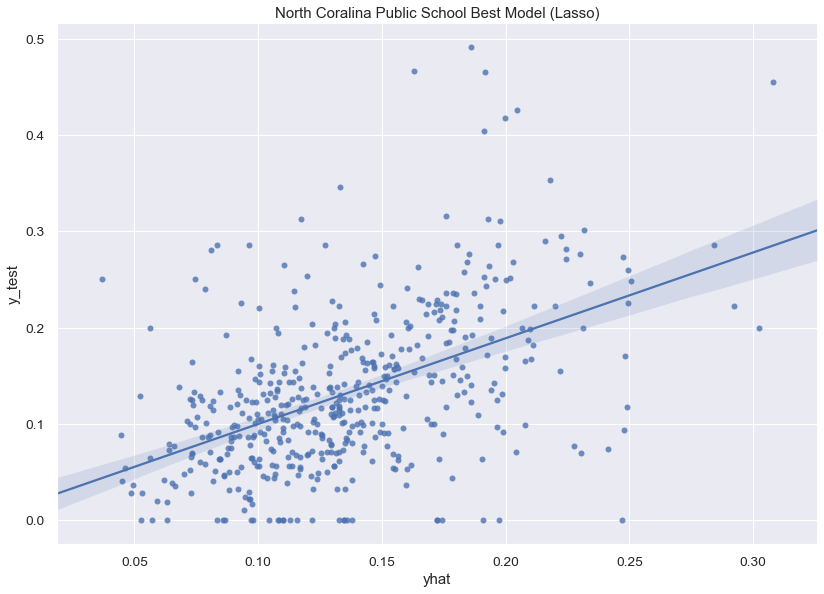

In [55]:
modelScore = pd.DataFrame([np.array(yhat),np.array(y_test)]).T
modelScore.columns=['yhat','y_test']

sns.lmplot(x="yhat", y="y_test",  data=modelScore,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("North Coralina Public School Best Model (Lasso)")
plt.ylabel('y_test')
plt.xlabel('yhat')
plt.savefig('Lasso_Model_Score.png')

## Residuals Plot

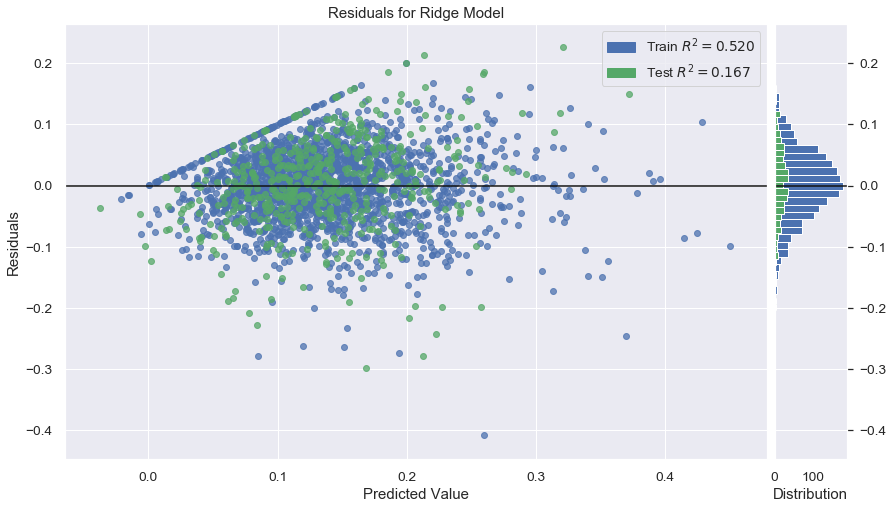

In [56]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

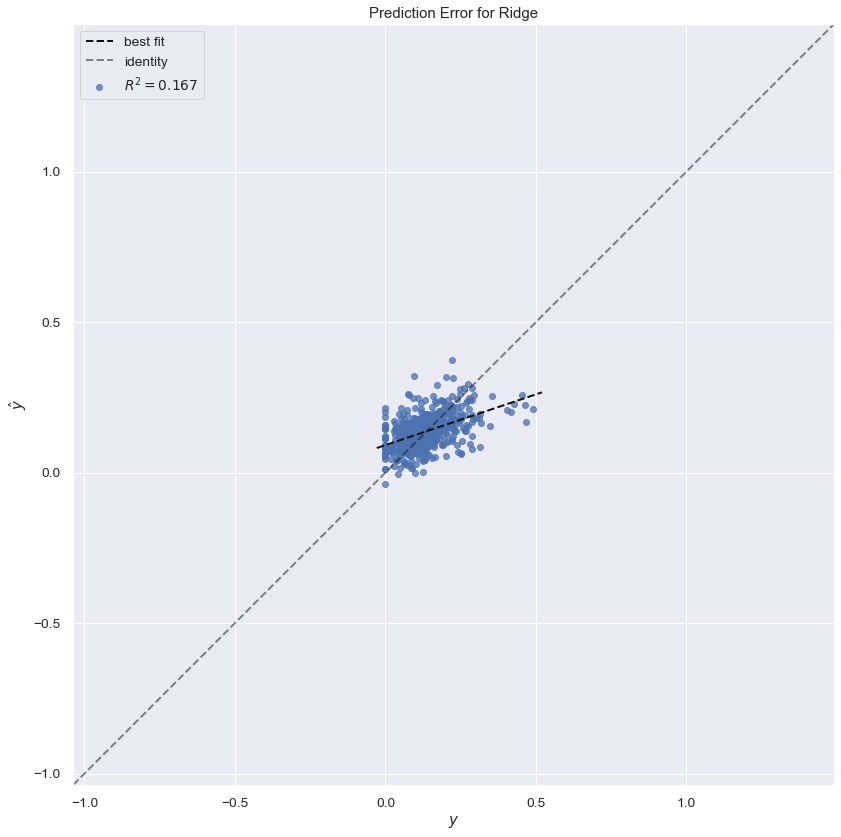

In [57]:


from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot()


visualizer = PredictionError(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()     

## XGBoost


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_reScaled, y, test_size=0.2,random_state =42)


In [79]:
import xgboost as xgb; print("XGBoost",xgb.__version__)

XGBoost 0.90


In [59]:
# credit: https://www.kaggle.com/priyadwivedi/kernel-ridge-regression-and-xgboost
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
def kaggle_rmse(true,pred):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return rmse

def r2_metric(true,pred):
    r2 = r2_score(true, pred)
    return r2

In [124]:
## Define a function to help fit chosen algorithm 
def modelfit(alg, useTrainCV=True, cv_folds=10, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        xgtest = xgb.DMatrix(X_test)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    #dtrain_exp = np.exp(dtrain_predictions)
    dtest_predictions = alg.predict(X_test)
    #dvalid_exp = np.exp(dvalid_predictions)
            
    #Print model report:
    mae_train = mean_absolute_error(y_train, dtrain_predictions )
    mae_test = mean_absolute_error(y_test, dtest_predictions )
    mse_train = mean_squared_error(y_train, dtrain_predictions )
    mse_test = mean_squared_error(y_test, dtest_predictions )
    rmse_train = kaggle_rmse(y_train, dtrain_predictions )
    rmse_test = kaggle_rmse(y_test, dtest_predictions )
    r2 = r2_metric(y_test,dtest_predictions)
    print("MAE Train: %.4f"%mae_train)
    print("MAE Test: %.4f "%mae_test)
    print("MSE Train: %.4f"%mse_train)
    print("MSE Test: %.4f"%mse_test)
    print("RMSE Train %.4f"%rmse_train)
    print("RMSE Test: %.4f"% rmse_test)
    print("R2 - Test:%.4f"% r2)
    
    #print(pd.Series(alg.booster()))
                     
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp = feat_imp[0:50]
    feat_imp.to_csv("XGBoost_FeatureImportance.csv")
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return [alg,mae_test,mse_test,rmse_test]

In [93]:
# %%time
# # A parameter grid for XGBoost
# # https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
# params = {'min_child_weight':[1,4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)]
#           ,'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [3,5]
#           ,'n_estimators':range(50,200,50)
#           ,'learning_rate':[0.1],
          
#           }

# # Initialize XGB and GridSearch
# xgbReg = xgb.XGBRegressor(nthread=-1,objective= 'reg:squarederror') 

# grid = GridSearchCV(xgbReg, params)
# grid.fit(X_re, y)

# # Print the r2 score
# #print(r2_score(y_test, grid.best_estimator_.predict(X_test))) 

# # Save the file
# xgbEstimator = grid.best_estimator_
# xgby_hat = xgbEstimator.predict(X_test)
# #results_df = pd.DataFrame(data={'y':y_test}) 
# print("Yhat Min: ", xgby_hat.min(),"Yhat Max: ", xgby_hat.max(),"Yhat Mean: ", xgby_hat.mean(),"Yhat Std: ", xgby_hat.std())
# print("Explained variance Score:%.3f"%(explained_variance_score(y_test,xgby_hat, multioutput='uniform_average')))

Yhat Min:  0.09828681 Yhat Max:  0.27763212 Yhat Mean:  0.1352682 Yhat Std:  0.03018798
Explained variance Score:0.214
Wall time: 39min 6s


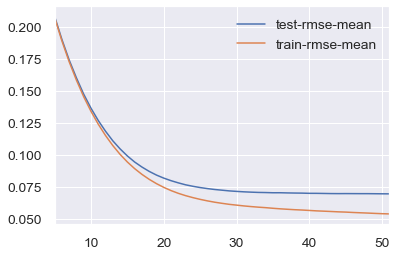

In [64]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)
params = {"max_depth":3, "eta":0.1, "min_child_weight":3,
 "gamma":0,
 "subsample":0.8,
 "colsample_bytree" :0.9,
 "objective": 'reg:squarederror',
 "scale_pos_weight":1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[5:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [108]:
xgb_Score = pd.DataFrame([np.array(pred_xgb),np.array(y_test)]).T
xgb_Score.columns=['pred_xgb','y_test']

sns.lmplot(x="pred_xgb", y="y_test",  data=xgb_Score,height=8.27, aspect=11.7/8.27)
sns.despine()

plt.title("North Coralina Public School Best Model (XGBoost)")
plt.ylabel('y_test')
plt.xlabel('pred_xgb')
plt.savefig('XGB_Model_Score.png')

NameError: name 'pred_xgb' is not defined

In [ ]:


# from sklearn import metrics   #Additional scklearn functions
# from sklearn.model_selection import ShuffleSplit, cross_validate
# from sklearn.model_selection import GridSearchCV   #Perforing grid search

# import matplotlib.pylab as plt
# %matplotlib inline
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 12, 4

In [ ]:

# print("MAE Score: %.5f "%mean_absolute_error(y_test,pred_xgb ))
# print("MSE Score: %.5f"%mean_squared_error(y_test,pred_xgb))
# print("RMSE Score: %.5f"%kaggle_rmse(y_test,pred_xgb))
# print("Explained Variance Score: %.5f"%explained_variance_score(y_test,pred_xgb, multioutput='uniform_average'))

In [ ]:
# dtrain = xgb.DMatrix(X_train, label = y_train)
# dtest = xgb.DMatrix(X_test)
# params = {"max_depth":5, "eta":0.1, "min_child_weight":1,
#  "gamma":0,
#  "subsample":0.8,
#  "colsample_bytree" :0.8,
#  #"objective": 'reg:squarederror',
#  "scale_pos_weight":1}
# model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
# model.loc[10:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [110]:
modelCompare

EstimatorName                                      BestEstimator  \
2             Lasso  Lasso(alpha=0.001, copy_X=True, fit_intercept=...   
4        ElasticNet  ElasticNet(alpha=0.001, copy_X=True, fit_inter...   
3             Ridge  Ridge(alpha=20, copy_X=True, fit_intercept=Tru...   
1               SVR  LinearRegression(copy_X=True, fit_intercept=Tr...   
0  LinearRegression  LinearRegression(copy_X=True, fit_intercept=Tr...   

        MAE       MSE      RMSE  
2  0.054731  0.005243  0.072330  
4  0.056096  0.005401  0.073383  
3  0.056689  0.005564  0.074544  
1  0.057994  0.005698  0.075426  
0  0.058203  0.006295  0.078618

MAE Train: 0.0316
MAE Test: 0.0529 
MSE Train: 0.0016
MSE Test: 0.0051
RMSE Train 0.0398
RMSE Test: 0.0711
R2 - Test:0.2565


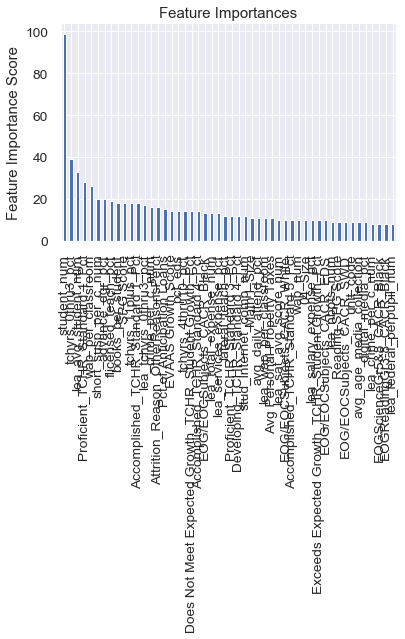

In [125]:
#C Start with a learning rate = 0.1 and look at Kaggle score and no of features 
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=27)

scores = modelfit(xgb1)
i=len(modelCompare)
modelCompare.loc[i] = ['xgb1',scores[0],scores[1],scores[2],scores[3]]


MAE Train: 0.0432
MAE Test: 0.0528 
MSE Train: 0.0031
MSE Test: 0.0050
RMSE Train 0.0556
RMSE Test: 0.0710
R2 - Test:0.2594


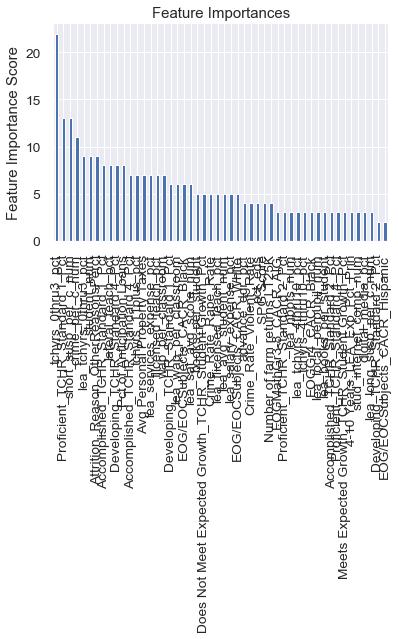

In [134]:
# Best tuned 
# max_depth =3 , min_child_weight: 3, gamma = 0, learning_rate = 0.1, 
#subsample = 0.8, colsample = 0.9, n_estimators = 400

xgb2 = xgb.XGBRegressor(
     learning_rate = 0.1,
     n_estimators=400,
     max_depth= 3,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.9,
     objective= 'reg:squarederror',
     scale_pos_weight=1,
     seed=27)

scores =  modelfit(xgb2)
i=len(modelCompare)
modelCompare.loc[i] = ['xgb2',scores[0],scores[1],scores[2],scores[3]]

In [ ]:
# dtrain = xgb.DMatrix(X_train, label = y_train)
# dtest = xgb.DMatrix(X_test)
# params = {"max_depth":3, "eta":0.1, "min_child_weight":3,
#  "gamma":0,
#  "subsample":0.8,
#  "colsample_bytree" :0.9,
#  #"objective": 'reg:squarederror',
#  "scale_pos_weight":1}
# model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
# model.loc[5:,["test-rmse-mean", "train-rmse-mean"]].plot()

MAE Train: 0.0437
MAE Test: 0.0528 
MSE Train: 0.0031
MSE Test: 0.0050
RMSE Train 0.0558
RMSE Test: 0.0705
R2 - Test:0.2701
Wall time: 2min 42s


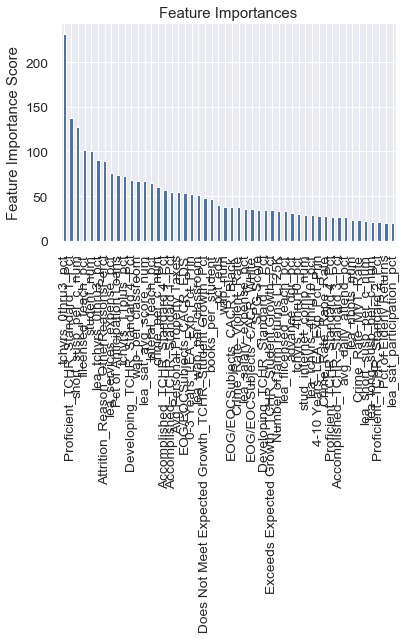

In [130]:
%%time
# Final model - reduce learning rate and add a lot of estimators
xgb4 = xgb.XGBRegressor(
     learning_rate = 0.01,
     n_estimators=5000,
     max_depth= 3,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.9,
     objective= 'reg:squarederror',
     scale_pos_weight=1,
     seed=27)

scores = modelfit(xgb4)
i=len(modelCompare)
modelCompare.loc[i] = ['xgb4',scores[0],scores[1],scores[2],scores[3]]

In [131]:
modelCompare

EstimatorName                                      BestEstimator  \
0  LinearRegression  LinearRegression(copy_X=True, fit_intercept=Tr...   
1               SVR  LinearRegression(copy_X=True, fit_intercept=Tr...   
2             Lasso  Lasso(alpha=0.001, copy_X=True, fit_intercept=...   
3             Ridge  Ridge(alpha=20, copy_X=True, fit_intercept=Tru...   
4        ElasticNet  ElasticNet(alpha=0.001, copy_X=True, fit_inter...   
5              xgb1  XGBRegressor(base_score=0.5, booster='gbtree',...   
6              xgb2  XGBRegressor(base_score=0.5, booster='gbtree',...   
7              xgb4  XGBRegressor(base_score=0.5, booster='gbtree',...   

        MAE       MSE      RMSE  
0  0.058203  0.006295  0.078618  
1  0.057994  0.005698  0.075426  
2  0.054731  0.005243  0.072330  
3  0.056689  0.005564  0.074544  
4  0.056096  0.005401  0.073383  
5  0.052866  0.005058  0.071118  
6  0.052761  0.005038  0.070982  
7  0.052755  0.004966  0.070467

In [133]:
%%time
# Best regressor
model_xgb = xgb.XGBRegressor(
     learning_rate = 0.01,
     n_estimators=5000,
     max_depth=3,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.9,
     objective= 'reg:squarederror',
     scale_pos_weight=1,
     seed=27)

model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)
pred_xgb = xgb_preds
pred_xgb[:5]


TypeError: 'XGBRegressor' object does not support indexing

In [ ]:
# feat_imp = pd.Series(model_xgb.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp = feat_imp[0:50]
# feat_imp.plot(kind='bar', title='XGBoost Final Model Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.savefig("XGBoost_Feature_Importance.png")

In [ ]:
# print(y_test.min(), y_test.max(), y_test.mean())
# print(pred_xgb.min(), pred_xgb.max(), pred_xgb.mean(),pred_xgb.std())

Best: -0.051886 using {'n_estimators': 100}
-0.133561 (0.003955) with: {'n_estimators': 10}
-0.068739 (0.002809) with: {'n_estimators': 20}
-0.055568 (0.002400) with: {'n_estimators': 30}
-0.053053 (0.002375) with: {'n_estimators': 40}
-0.052353 (0.002432) with: {'n_estimators': 50}
-0.052125 (0.002421) with: {'n_estimators': 60}
-0.052031 (0.002489) with: {'n_estimators': 70}
-0.052007 (0.002409) with: {'n_estimators': 80}
-0.051970 (0.002480) with: {'n_estimators': 90}
-0.051886 (0.002513) with: {'n_estimators': 100}
-0.051952 (0.002530) with: {'n_estimators': 110}
-0.051989 (0.002541) with: {'n_estimators': 120}
-0.052063 (0.002545) with: {'n_estimators': 130}
-0.052118 (0.002579) with: {'n_estimators': 140}
-0.052098 (0.002546) with: {'n_estimators': 150}
-0.052131 (0.002565) with: {'n_estimators': 160}
-0.052190 (0.002560) with: {'n_estimators': 170}
-0.052245 (0.002566) with: {'n_estimators': 180}
-0.052281 (0.002632) with: {'n_estimators': 190}
-0.052297 (0.002591) with: {'n_est

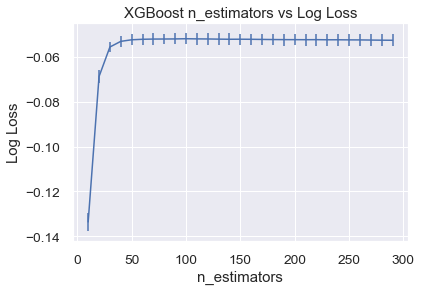

In [88]:
# X = X_reScaled

# model = xgb.XGBRegressor(nthread=-1,objective= 'reg:squarederror')
# n_estimators = range(10, 300, 10)
# param_grid = dict(n_estimators=n_estimators)
# kfold = 10#StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, scoring='neg_mean_absolute_error')
# grid_result=grid_search.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# # plot
# plt.errorbar(n_estimators, means, yerr=stds)
# plt.title("XGBoost n_estimators vs Log Loss")
# plt.xlabel('n_estimators')
# plt.ylabel('Log Loss')
# plt.savefig('n_estimators.png')

range(1, 11, 2)
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   54.7s finished


Best: -0.051886 using {'max_depth': 3}
-0.053211 (0.002042) with: {'max_depth': 1}
-0.051886 (0.002513) with: {'max_depth': 3}
-0.052699 (0.002586) with: {'max_depth': 5}
-0.053365 (0.002832) with: {'max_depth': 7}
-0.053421 (0.002402) with: {'max_depth': 9}


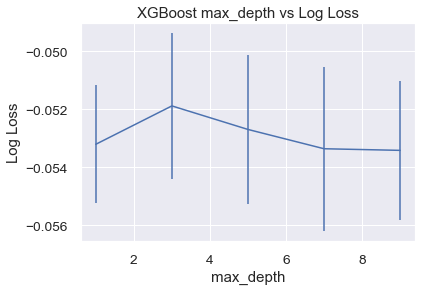

In [91]:
# # grid search
# model = xgb.XGBRegressor(nthread=-1,objective= 'reg:squarederror')
# max_depth = range(1, 11, 2)
# print(max_depth)
# param_grid = dict(max_depth=max_depth)
# kfold =10 # StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold, verbose=1)
# grid_result = grid_search.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# # plot
# plt.errorbar(max_depth, means, yerr=stds)
# plt.title("XGBoost max_depth vs Log Loss")
# plt.xlabel('max_depth')
# plt.ylabel('Log Loss')
# plt.savefig('max_depth.png')